# Music genre classification project

## Описание проекта  

**Задача проекта**  
Классификация музыкальных треков по жанрам. 

В нашем распоряжении датасет с описанием музыкальных треков.  
Данные взяты с сайта [Kaggle.com](https://www.kaggle.com/), ссылка на страничку датасета: [Prediction of music genre](https://www.kaggle.com/datasets/vicsuperman/prediction-of-music-genre/data?select=music_genre.csv).  

Датасет представляет собой табличные данные формата csv.  
Описание колонок:  
- instance_id (уникальное ID для каждого трека);  
- признаковое описание:  
    - artist_name;  
    - track_name;  
    - popularity;  
    - acousticness;  
    - danceability;  
    - duration_ms;  
    - energy;  
    - instrumentalness;  
    - key;  
    - liveness;  
    - loudness;  
    - mode;  
    - speechiness;  
    - tempo;  
    - obtained_date;  
    - valence;  
- music_genre (целевая переменная).    

Всего записей в датасете 50005.  

Целевая переменная имеет 10 значений классов (музыкальных жанров): 'Electronic', 'Anime',   
'Jazz', 'Alternative', 'Country', 'Rap', 'Blues', 'Rock', 'Classical', 'Hip-Hop'.  

Этапы выполнения проекта:  
- загрузка данных и библиотек;  
- предобработка и исследовательский анализ данных;
- исследование моделей;  
- тестирование лучшей модели;  
- анализ важности признаков для лучшей модели;  
- общий вывод по проекту.

## 1. Загрузка данных и библиотек

Загрузим необходимые библиотеки

In [52]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import phik

from sklearn.model_selection import train_test_split, GridSearchCV, \
                                    RandomizedSearchCV
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder, \
                                  OrdinalEncoder, StandardScaler, \
                                  MinMaxScaler, Normalizer, RobustScaler, \
                                  PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, \
                            classification_report, precision_recall_curve, \
                            f1_score, make_scorer, recall_score
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector, \
                            make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from imblearn.base import FunctionSampler
from imblearn.pipeline import make_pipeline as make_imblearn_pipeline
from imblearn.combine import SMOTETomek

import catboost as cb

from feature_engine.selection import DropCorrelatedFeatures, \
                                     DropConstantFeatures

import shap

import warnings
warnings.filterwarnings('ignore')

Определим глобалные переменные

In [2]:
DATA_DIR = 'data/music_genre.csv'
RANDOM_STATE = 42

Установим параметры seaborn

In [3]:
sns.set_style('whitegrid',
             {'axes.facecolor': '0.85',
              'axes.edgecolor': '0.15',
              'grid.color': '0.7',
              'figure.facecolor': '0.9'})

Загрузим данные

In [4]:
data = pd.read_csv(DATA_DIR)

Данные загружены, можем приступать к следующему этапу

## 2. Предобработка и исследовательский анализ данных

Посмотрим на несколько случайных строчек датасета

In [5]:
data.sample(10)

instance_id               artist_name  \
11025      74820.0                     Plini   
30050      48955.0      Tedeschi Trucks Band   
28428      48165.0                   Dr. Dre   
47101      43050.0                       NAV   
15130      53446.0                Papa Roach   
20729      89541.0           Waylon Jennings   
31287      63849.0                      Free   
20448      52441.0               Johnny Cash   
8904       65020.0                  livetune   
41699      20573.0  Pyotr Ilyich Tchaikovsky   

                                            track_name  popularity  \
11025                              Every Piece Matters        48.0   
30050                      Darling Be Home Soon - Live        27.0   
28428                                        Bang Bang        55.0   
47101                                 Did You See NAV?        56.0   
15130                                  American Dreams        54.0   
20729                    Old Five and Dimers (Like Me)        39.0   
31287                                      I'm A Mover        26.0   
20448             The Night Hank Williams Came To Town        41.0   
8904                                   Tell Your World        41.0   
41699  The Seasons, Op. 37a: XII. December - Christmas        32.0   

       acousticness  danceability  duration_ms  energy  instrumentalness key  \
11025       0.08720         0.673     220213.0  0.6440          0.664000  C#   
30050       0.48600         0.404     604760.0  0.3850          0.005990   A   
28428       0.13000         0.863     222320.0  0.8800          0.000000   F   
47101       0.01220         0.883     217187.0  0.4550          0.000070  C#   
15130       0.00122         0.587     203119.0  0.8790          0.000000   D   
20729       0.72200         0.651     186467.0  0.2140          0.053300   A   
31287       0.02190         0.457     178360.0  0.4830          0.000024   G   
20448       0.14700         0.599     202827.0  0.5750          0.000013   G   
8904        0.19000         0.592     254640.0  0.9750          0.000000  D#   
41699       0.99000         0.405     220373.0  0.0521          0.917000  G#   

       liveness  loudness   mode  speechiness              tempo  \
11025    0.2500    -8.158  Major       0.0275              110.0   
30050    0.7040   -11.568  Major       0.0334                  ?   
28428    0.1100    -2.500  Minor       0.1490  95.31200000000001   
47101    0.1140    -8.338  Major       0.0667            130.442   
15130    0.1250    -5.887  Major       0.0547            108.905   
20729    0.0958   -15.843  Major       0.0283             82.598   
31287    0.0933   -11.356  Major       0.0512            148.746   
20448    0.1050   -10.392  Major       0.0378             91.531   
8904     0.1960    -4.038  Major       0.0657             150.01   
41699    0.1330   -25.993  Major       0.0376             119.82   

      obtained_date  valence  music_genre  
11025         4-Apr    0.604         Jazz  
30050         4-Apr    0.283        Blues  
28428         4-Apr    0.768          Rap  
47101         4-Apr    0.129      Hip-Hop  
15130         4-Apr    0.395  Alternative  
20729         4-Apr    0.496      Country  
31287         4-Apr    0.816        Blues  
20448         4-Apr    0.615      Country  
8904          4-Apr    0.209        Anime  
41699         3-Apr    0.233    Classical

Выведем общую информацию о датасетах

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50005 entries, 0 to 50004
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       50000 non-null  float64
 1   artist_name       50000 non-null  object 
 2   track_name        50000 non-null  object 
 3   popularity        50000 non-null  float64
 4   acousticness      50000 non-null  float64
 5   danceability      50000 non-null  float64
 6   duration_ms       50000 non-null  float64
 7   energy            50000 non-null  float64
 8   instrumentalness  50000 non-null  float64
 9   key               50000 non-null  object 
 10  liveness          50000 non-null  float64
 11  loudness          50000 non-null  float64
 12  mode              50000 non-null  object 
 13  speechiness       50000 non-null  float64
 14  tempo             50000 non-null  object 
 15  obtained_date     50000 non-null  object 
 16  valence           50000 non-null  float6

In [7]:
data.describe()

instance_id    popularity  acousticness  danceability   duration_ms  \
count  50000.000000  50000.000000  50000.000000  50000.000000  5.000000e+04   
mean   55888.396360     44.220420      0.306383      0.558241  2.212526e+05   
std    20725.256253     15.542008      0.341340      0.178632  1.286720e+05   
min    20002.000000      0.000000      0.000000      0.059600 -1.000000e+00   
25%    37973.500000     34.000000      0.020000      0.442000  1.748000e+05   
50%    55913.500000     45.000000      0.144000      0.568000  2.192810e+05   
75%    73863.250000     56.000000      0.552000      0.687000  2.686122e+05   
max    91759.000000     99.000000      0.996000      0.986000  4.830606e+06   

             energy  instrumentalness      liveness      loudness  \
count  50000.000000      50000.000000  50000.000000  50000.000000   
mean       0.599755          0.181601      0.193896     -9.133761   
std        0.264559          0.325409      0.161637      6.162990   
min        0.000792          0.000000      0.009670    -47.046000   
25%        0.433000          0.000000      0.096900    -10.860000   
50%        0.643000          0.000158      0.126000     -7.276500   
75%        0.815000          0.155000      0.244000     -5.173000   
max        0.999000          0.996000      1.000000      3.744000   

        speechiness       valence  
count  50000.000000  50000.000000  
mean       0.093586      0.456264  
std        0.101373      0.247119  
min        0.022300      0.000000  
25%        0.036100      0.257000  
50%        0.048900      0.448000  
75%        0.098525      0.648000  
max        0.942000      0.992000

Первоначальные наблюдения:  
- имеем 5 пустых записей;  
- признаки instance_id, obtained_date не отражают информацию о треках, удалим их в дальнейшем;
- числовые признаки имееют значения, лежащие в разных диапазонах, их необходимо привести к одному масштабу перед обучением моделей;  
- в колонке tempo имеются записи с излишними знаками после запятой, также тип данных признака не соответствует действительности.

Удалим строчки с явными пропусками

In [8]:
data[data['instance_id'].isna()]

instance_id artist_name track_name  popularity  acousticness  \
10000          NaN         NaN        NaN         NaN           NaN   
10001          NaN         NaN        NaN         NaN           NaN   
10002          NaN         NaN        NaN         NaN           NaN   
10003          NaN         NaN        NaN         NaN           NaN   
10004          NaN         NaN        NaN         NaN           NaN   

       danceability  duration_ms  energy  instrumentalness  key  liveness  \
10000           NaN          NaN     NaN               NaN  NaN       NaN   
10001           NaN          NaN     NaN               NaN  NaN       NaN   
10002           NaN          NaN     NaN               NaN  NaN       NaN   
10003           NaN          NaN     NaN               NaN  NaN       NaN   
10004           NaN          NaN     NaN               NaN  NaN       NaN   

       loudness mode  speechiness tempo obtained_date  valence music_genre  
10000       NaN  NaN          NaN   NaN           NaN      NaN         NaN  
10001       NaN  NaN          NaN   NaN           NaN      NaN         NaN  
10002       NaN  NaN          NaN   NaN           NaN      NaN         NaN  
10003       NaN  NaN          NaN   NaN           NaN      NaN         NaN  
10004       NaN  NaN          NaN   NaN           NaN      NaN         NaN

In [9]:
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)

Определим переменные с числовыми и категориальными признаками и таргетом

In [10]:
target = 'music_genre'

number_columns = ['popularity',
                  'acousticness',
                  'danceability',
                  'duration_ms',
                  'energy',
                  'instrumentalness',
                  'liveness',
                  'loudness',
                  'speechiness',
                  'tempo',
                  'valence']

cat_columns = ['key',
               'mode']

Проверим наличие аномальных значений и неявных пропусков

In [11]:
for column in cat_columns:
    print(column)
    print(data[column].unique())

key
['A#' 'D' 'G#' 'C#' 'F#' 'B' 'G' 'F' 'A' 'C' 'E' 'D#']
mode
['Minor' 'Major']


В категориальных признаках аномальных значений не обнаружено

Исследуем признак 'tempo'

In [12]:
data[data['tempo'] == '?']['tempo']

5        ?
32       ?
35       ?
36       ?
39       ?
        ..
49913    ?
49959    ?
49962    ?
49971    ?
49972    ?
Name: tempo, Length: 4980, dtype: object

Как видим в данном признаке имеются некорректные значения.  
Посмотрим на распределение этих значений между признаками.

In [13]:
data[data['tempo'] == '?'][target].value_counts()

music_genre
Electronic     534
Blues          530
Country        514
Alternative    505
Anime          503
Classical      500
Rap            496
Hip-Hop        480
Jazz           479
Rock           439
Name: count, dtype: int64

Между признаками распределение практически равномерное. Пока заменим данные значения на нули, чтобы перевести признак в числовой формат и провести дальнейший анализ.

In [14]:
data.loc[data['tempo'] == '?', 'tempo'] = 0
data['tempo'] = data['tempo'].astype('float')

Проведем анализ числовых признаков

Напишем функцию для определения максимального количества записей в определенном диапозоне значений

In [15]:
def max_number(data: pd.DataFrame,
               column: str,
               bins:int = 10):
    """
    Return the maximum number of objects contained in the array ranges.
    
    :param data: dataset
    :type data: pd.DataFrame
    :param column: column name
    :type column: str
    :param bins: number of ranges, defaults to 10
    :type bins: int, optional
    
    :rtype: int
    return: maximum number of objects contained in bins
    """
    range_list = np.linspace(data[column].min(), data[column].max(), bins)
    number = 0
    for i in  range(1, bins):
        now_number = data.loc[(data[column] >= range_list[i-1]) &
                              (data[column] < range_list[i]),
                              column].count()
        if now_number > number:
            number = now_number
    return number

Напишем функцию для построения гистограмм

In [16]:
def draw_gist2(data: pd.DataFrame,
               column: str,
               bins:int = 10,
               figsize: list = [15, 8],
               range: list = None,
               display_desc = True,
               legend = True,
               alpha: float = 0.8,
               labels = True):
    """Вisplaying a histogram of a dataset column with median and average values and quartiles.
    
    :param data: dataset
    :type data: pd.Dataframe
    :param column: dataset column
    :type column: str
    :param bins: number of ranges, defaults to 10
    :type bins: int, optional
    :param figsize: the size of the figure, defaults to [15, 8]
    :type figsize: list, optional
    :param range: the display range of the feature, defaults to None
    :type range: list, optional
    :param display_desc: display the description, defaults to True,
    :type display_desc: boolean, optional
    :param legend: display the legend, defaults to True
    :type legend: boolean, optional 
    :param alpha: transparency coefficient, defaults to 0.8
    :type alpha: float, optional
    :param labels: display axis labels, defaults to True
    :type lables: boolean, optional
    """

    title = column
    x_label = 'value of ' + title
    y_label = 'number of records'

    #построение графика для категориальных признаков
    if data[column].dtype == 'O' or data[column].dtype == 'bool':

        display(data[column].describe())

        plt.figure(figsize=(15, 8))

        plt.bar(x = data[column].value_counts().index,
                height = data[column].value_counts().values)

        if legend:
            plt.legend(['value_count'])

        plt.title(title)

        if labels:
            plt.xlabel(x_label)
            plt.ylabel(y_label)
    
    #построение графиков для числовых признаков
    else:
        
        desc = data[column].describe()
        if display_desc:
            display(desc)
        
        #расчет значений IQR
        if desc[6] + 1.5*(desc[6] - desc[4]) > desc[7]:
            q_interval_r = desc[7]
        else:
            q_interval_r = desc[6] + 1.5*(desc[6] - desc[4])

        if desc[4] - 1.5*(desc[6] - desc[4]) < desc[3]:
            q_interval_l = desc[3]
        else:
            q_interval_l = desc[4] - 1.5*(desc[6] - desc[4])
        
        #построение гистограммы
        if range:
            data[column].plot(kind='hist', bins=bins, figsize=figsize,
                              range=range, grid=True, alpha=alpha)
        else:
            data[column].plot(kind='hist', bins=bins, figsize=figsize,
                              grid=True, alpha=alpha)
 
        #получение максимального количества элементов для одного столбца на гистограмме
        max_numb = max_number(data, column, bins+1)

        #построение квартилей, медианного и среднего значения
        plt.vlines(desc[4], 0, max_numb, color='y', linewidth=2,
                  linestyle='--', alpha=0.7)
        plt.vlines(desc[5], 0, max_numb, color='r', linewidth=2,
                  linestyle='--', alpha=0.7)
        plt.vlines(desc[6], 0, max_numb, color='y', linewidth=2,
                  linestyle='--', alpha=0.7)
        plt.vlines(desc[1], 0, max_numb, color='g', linewidth=2,
                  linestyle='--', alpha=0.7)

        plt.fill([desc[4], desc[4], desc[6], desc[6]],
                 [0, max_numb, max_numb, 0],
                 'y', alpha=0.15)

        plt.vlines(q_interval_l, 0, max_numb, color='black',
                   linewidth=1, linestyle='--', alpha=0.7)
        plt.vlines(q_interval_r, 0, max_numb, color='black',
                   linewidth=1, linestyle='--', alpha=0.7)
        
        if legend:
            plt.legend(['value_count', 'Q1', 'Q2', 'Q3', 'mean', 'BOX',
                        'Q1-1.5IQR', 'Q3+1.5IQR'])
        plt.title(title)
        if labels:
            plt.xlabel(x_label)
            plt.ylabel(y_label)

popularity


count    50000.000000
mean        44.220420
std         15.542008
min          0.000000
25%         34.000000
50%         45.000000
75%         56.000000
max         99.000000
Name: popularity, dtype: float64

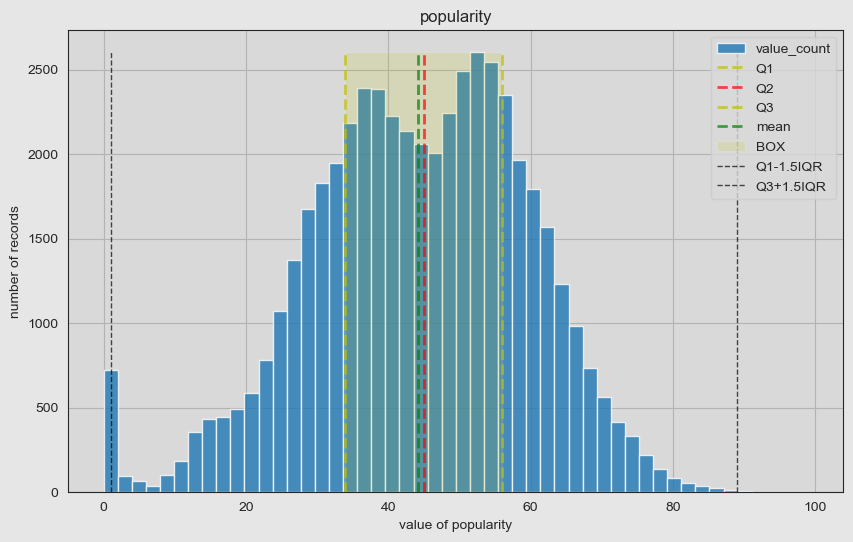

acousticness


count    50000.000000
mean         0.306383
std          0.341340
min          0.000000
25%          0.020000
50%          0.144000
75%          0.552000
max          0.996000
Name: acousticness, dtype: float64

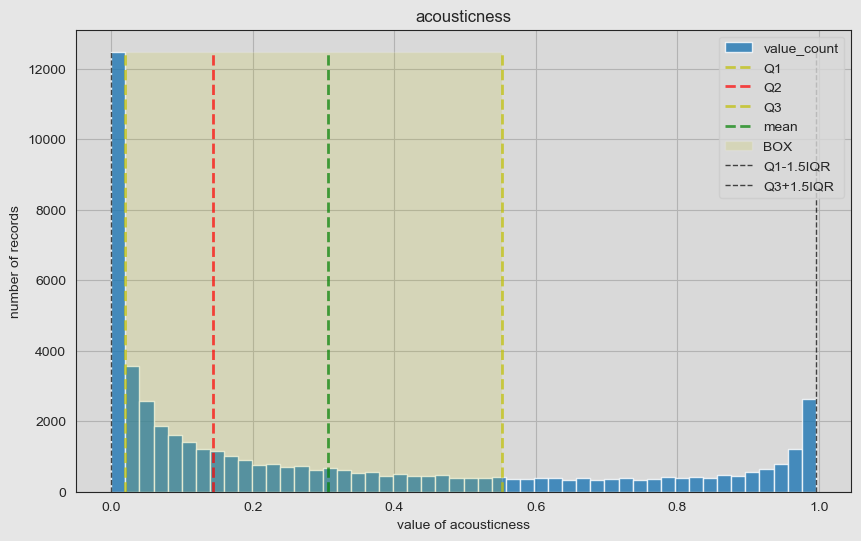

danceability


count    50000.000000
mean         0.558241
std          0.178632
min          0.059600
25%          0.442000
50%          0.568000
75%          0.687000
max          0.986000
Name: danceability, dtype: float64

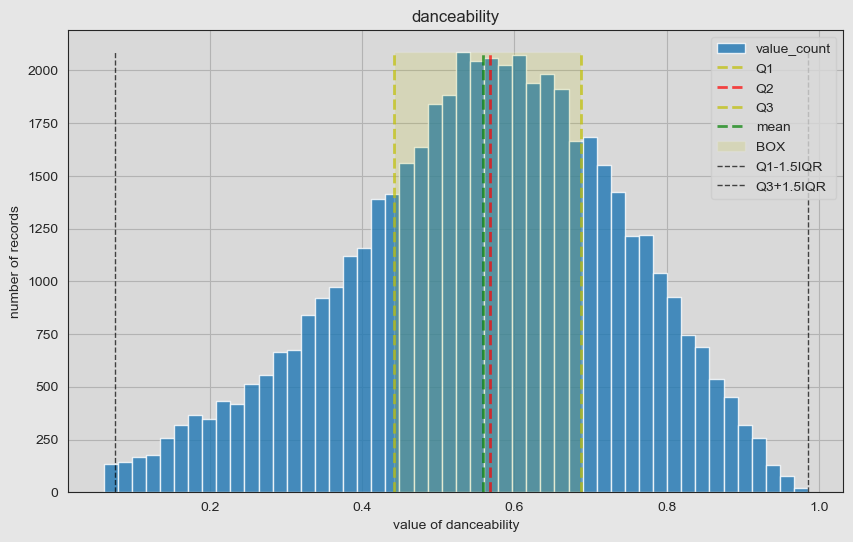

duration_ms


count    5.000000e+04
mean     2.212526e+05
std      1.286720e+05
min     -1.000000e+00
25%      1.748000e+05
50%      2.192810e+05
75%      2.686122e+05
max      4.830606e+06
Name: duration_ms, dtype: float64

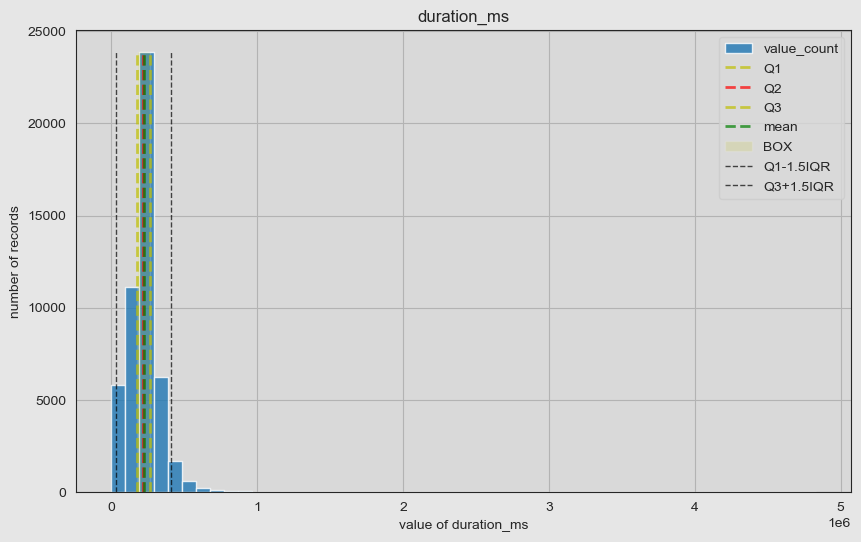

energy


count    50000.000000
mean         0.599755
std          0.264559
min          0.000792
25%          0.433000
50%          0.643000
75%          0.815000
max          0.999000
Name: energy, dtype: float64

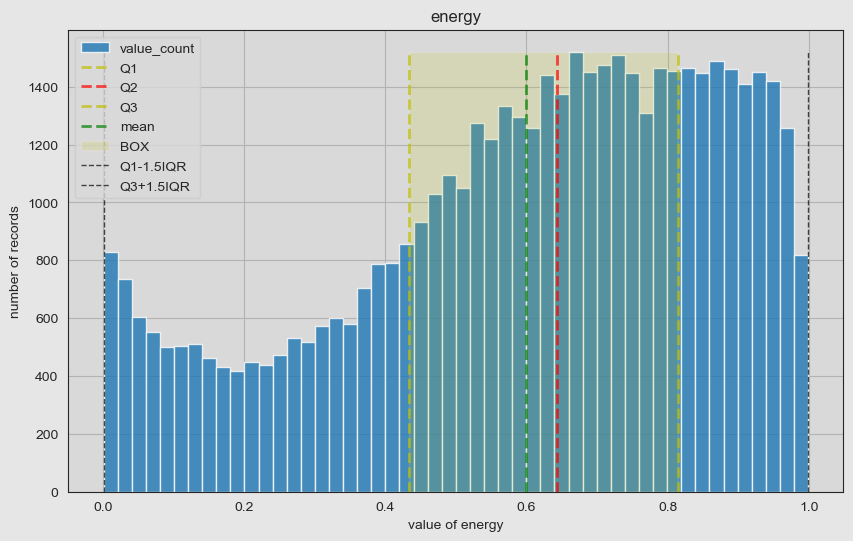

instrumentalness


count    50000.000000
mean         0.181601
std          0.325409
min          0.000000
25%          0.000000
50%          0.000158
75%          0.155000
max          0.996000
Name: instrumentalness, dtype: float64

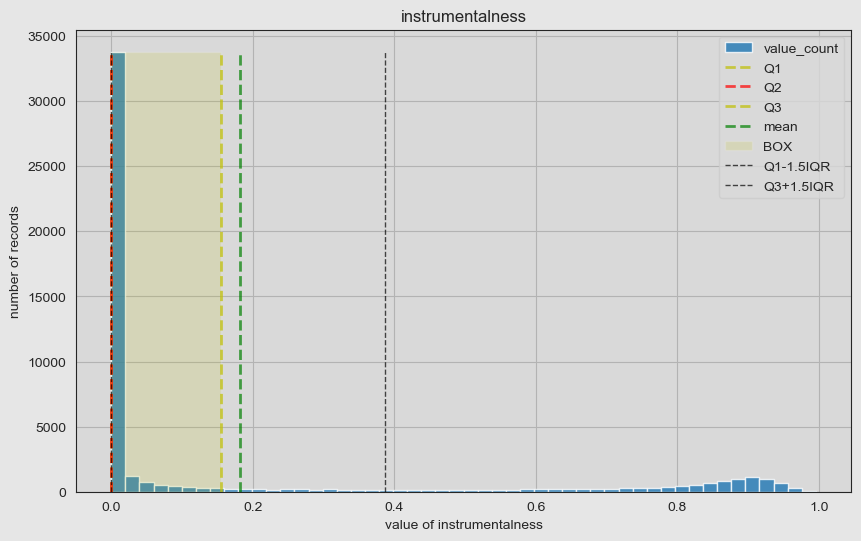

liveness


count    50000.000000
mean         0.193896
std          0.161637
min          0.009670
25%          0.096900
50%          0.126000
75%          0.244000
max          1.000000
Name: liveness, dtype: float64

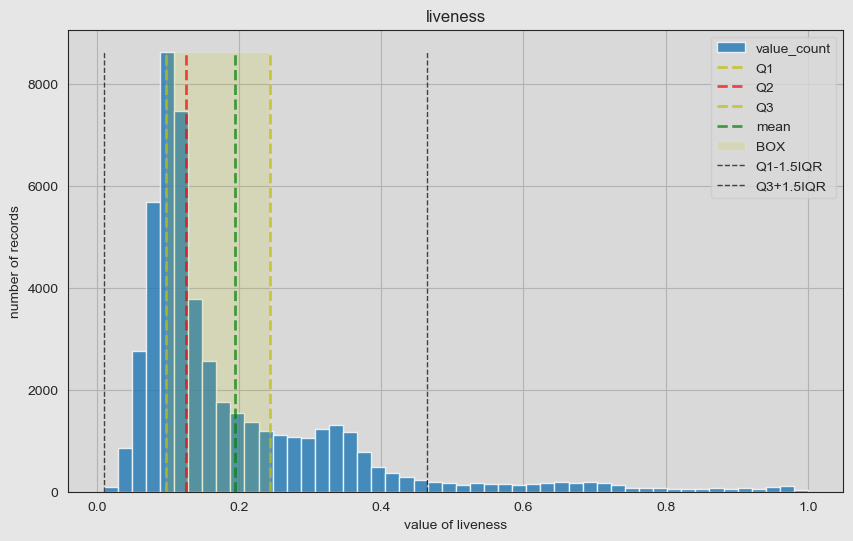

loudness


count    50000.000000
mean        -9.133761
std          6.162990
min        -47.046000
25%        -10.860000
50%         -7.276500
75%         -5.173000
max          3.744000
Name: loudness, dtype: float64

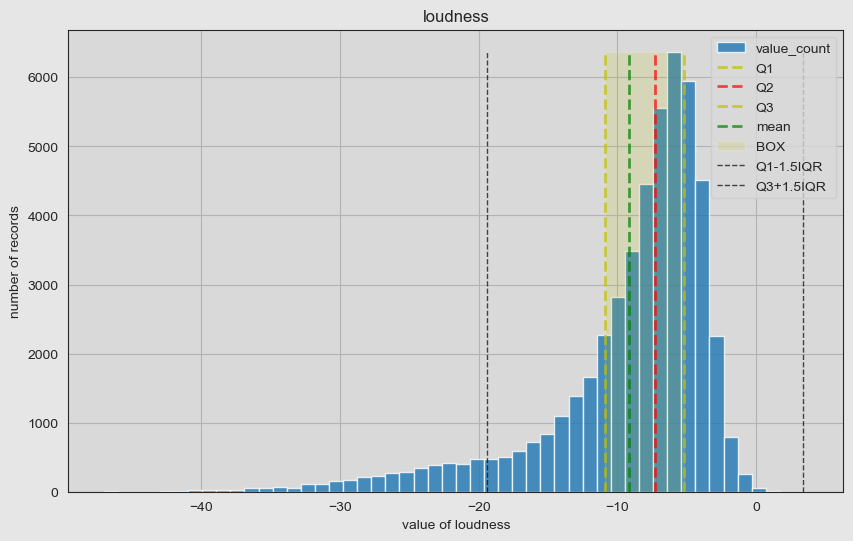

speechiness


count    50000.000000
mean         0.093586
std          0.101373
min          0.022300
25%          0.036100
50%          0.048900
75%          0.098525
max          0.942000
Name: speechiness, dtype: float64

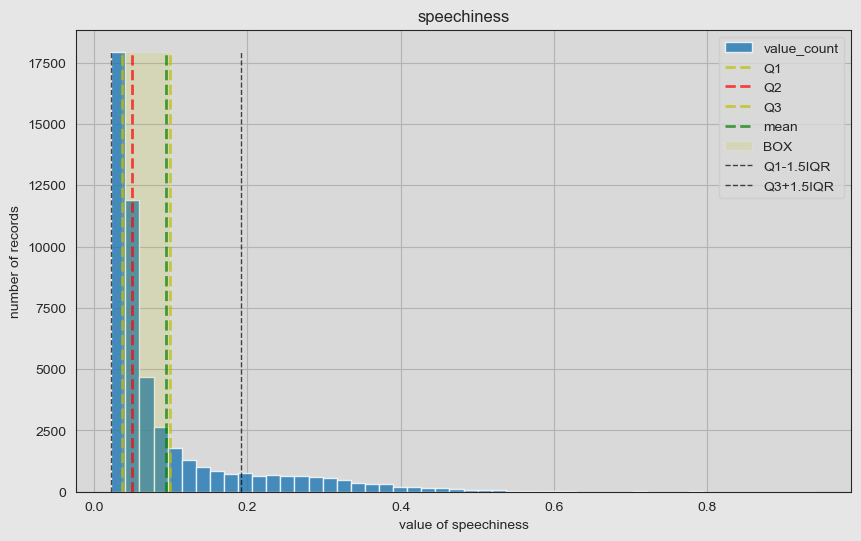

tempo


count    50000.000000
mean       108.005646
std         46.214710
min          0.000000
25%         87.983000
50%        113.779000
75%        139.468250
max        220.276000
Name: tempo, dtype: float64

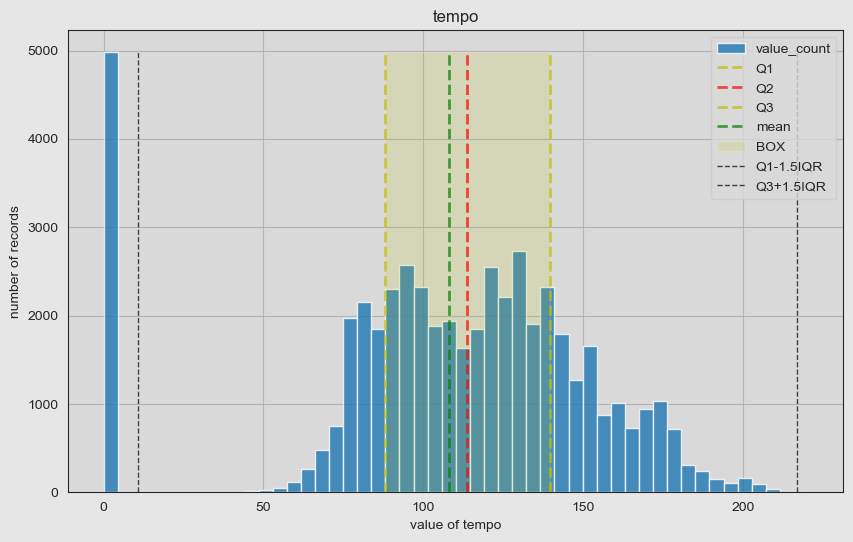

valence


count    50000.000000
mean         0.456264
std          0.247119
min          0.000000
25%          0.257000
50%          0.448000
75%          0.648000
max          0.992000
Name: valence, dtype: float64

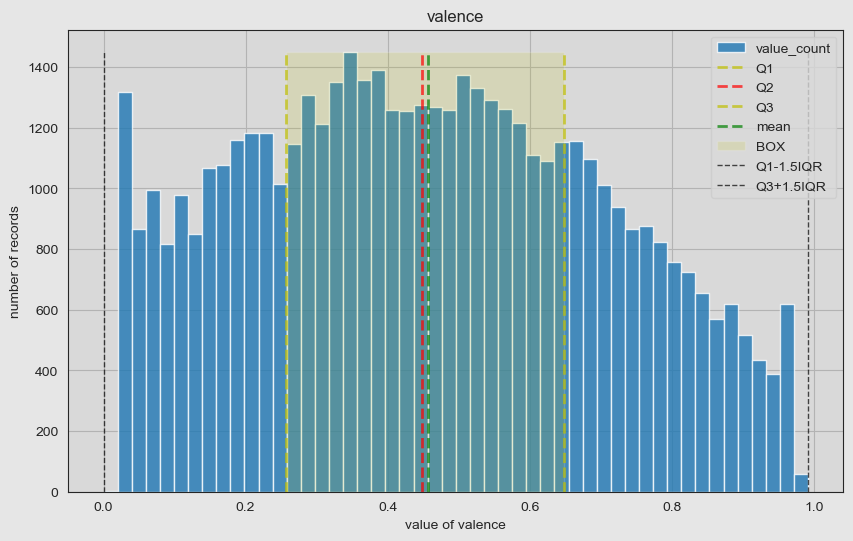

In [17]:
for column in number_columns:
    print(column)
    draw_gist2(data,
               column,
               bins=50,
               figsize=[10, 6],
               alpha=0.8)
    plt.show()

У признака duration_ms минимальное значение равняется -1, что некорректно. Данный признак необходимо исследовать подробнее.  
Примечательно, что у признака instrumentalness среднее значение выходит за пределы 3-го квартиля, а медианное значени совпадает с 1-ым квартилем.  
У признаков duration_ms, instrumentalness, liveness, loudness, speechiness имеются выбросы, но мы не можем исключать музыкальные треки с нестандартными характеристиками.  
В дальнейшем проанализируем распределение признаков для каждого музыкального жанра.

Подробнее изучим признак duration_ms

In [18]:
data['duration_ms'].value_counts()

duration_ms
-1.0         4939
 240000.0      33
 192000.0      32
 180000.0      28
 216000.0      20
             ... 
 154574.0       1
 359213.0       1
 656213.0       1
 506320.0       1
 189483.0       1
Name: count, Length: 26028, dtype: int64

In [19]:
data[data['duration_ms'] > 1e+06][target].value_counts()

music_genre
Classical     60
Blues         13
Electronic     8
Jazz           8
Anime          4
Name: count, dtype: int64

In [20]:
data[data['duration_ms'] == -1][target].value_counts()

music_genre
Rap            512
Classical      511
Rock           507
Jazz           497
Country        492
Alternative    491
Hip-Hop        490
Electronic     483
Blues          483
Anime          473
Name: count, dtype: int64

Как видим, распределение некорректных значений между классами таргета практически равномерное.  
Большинство значений, попадающих в диапазон выбросов, принадлежат к классу classilac, что вполне логично.

Посмотрим на распределение категориальных признаков.

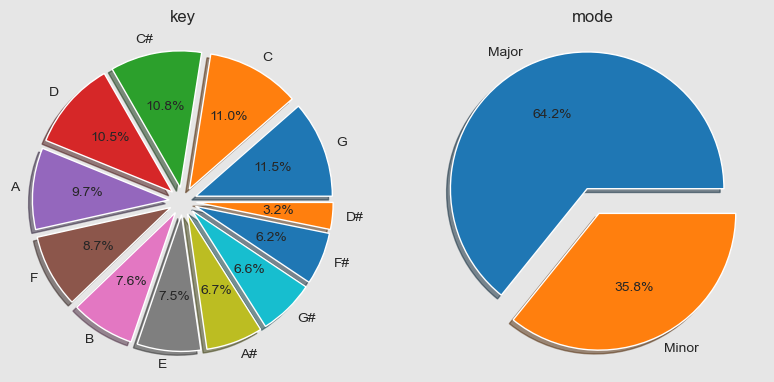

In [21]:
plt.figure(figsize=(15, 10))

for i, column in enumerate(cat_columns):
    plt.subplot(2, 3, i+1)
    freq = data[column].value_counts()
    plt.pie(x=freq.values, labels=freq.index, autopct='%1.1f%%',
            explode=np.ones(freq.shape[0])*0.1, shadow=True,)
    plt.title(column)

plt.show()

Проверим датасет на наличие явных дубликатов

In [22]:
print('Число дубликатов, включая все столбцы:')
print(data.duplicated().sum())
print('Число дубликатов в столбце instance_id:')
print(data['instance_id'].duplicated().sum())
print('Число дубликатов без столбца instance_id:')
print(data.iloc[:, 1:].duplicated().sum())
print('Число дубликатов без столбцов instance_id, artist_name, track_name')
print(data.iloc[:, 2:].duplicated().sum())

Число дубликатов, включая все столбцы:
0
Число дубликатов в столбце instance_id:
0
Число дубликатов без столбца instance_id:
0
Число дубликатов без столбцов instance_id, artist_name, track_name
0


Явных дубликатов не обнаружено.

Для дальнейшего анализы вырежем из датасета столбы instance_id, artist_name, track_name и obtained_date, также вырежем строки с некорректными значениями в столбцах tempo и duration_ms

In [23]:
data_clean = data.drop(['instance_id', 'artist_name', 'track_name', 'obtained_date'], axis=1)
data_clean = data_clean[~((data_clean['tempo'] == 0) | (data_clean['duration_ms'] == -1))]

Отобразим средние и медианные значения признаков для каждого музыкального жанра

In [24]:
data_clean.pivot_table(index = target,
                       values = number_columns,
                       aggfunc = ['median', 'mean']
                       ).style.background_gradient('coolwarm')

Из таблицы видно, что classical имеет признаковое описание наибольшим образом отличающееся от других жанров.  
Признак dancaebility можно выделить как наиболее информативный, поскольку его медианные значения отличаются для каждого музыкального жанра. 

Отобразим распределения признаков для каждого жанра

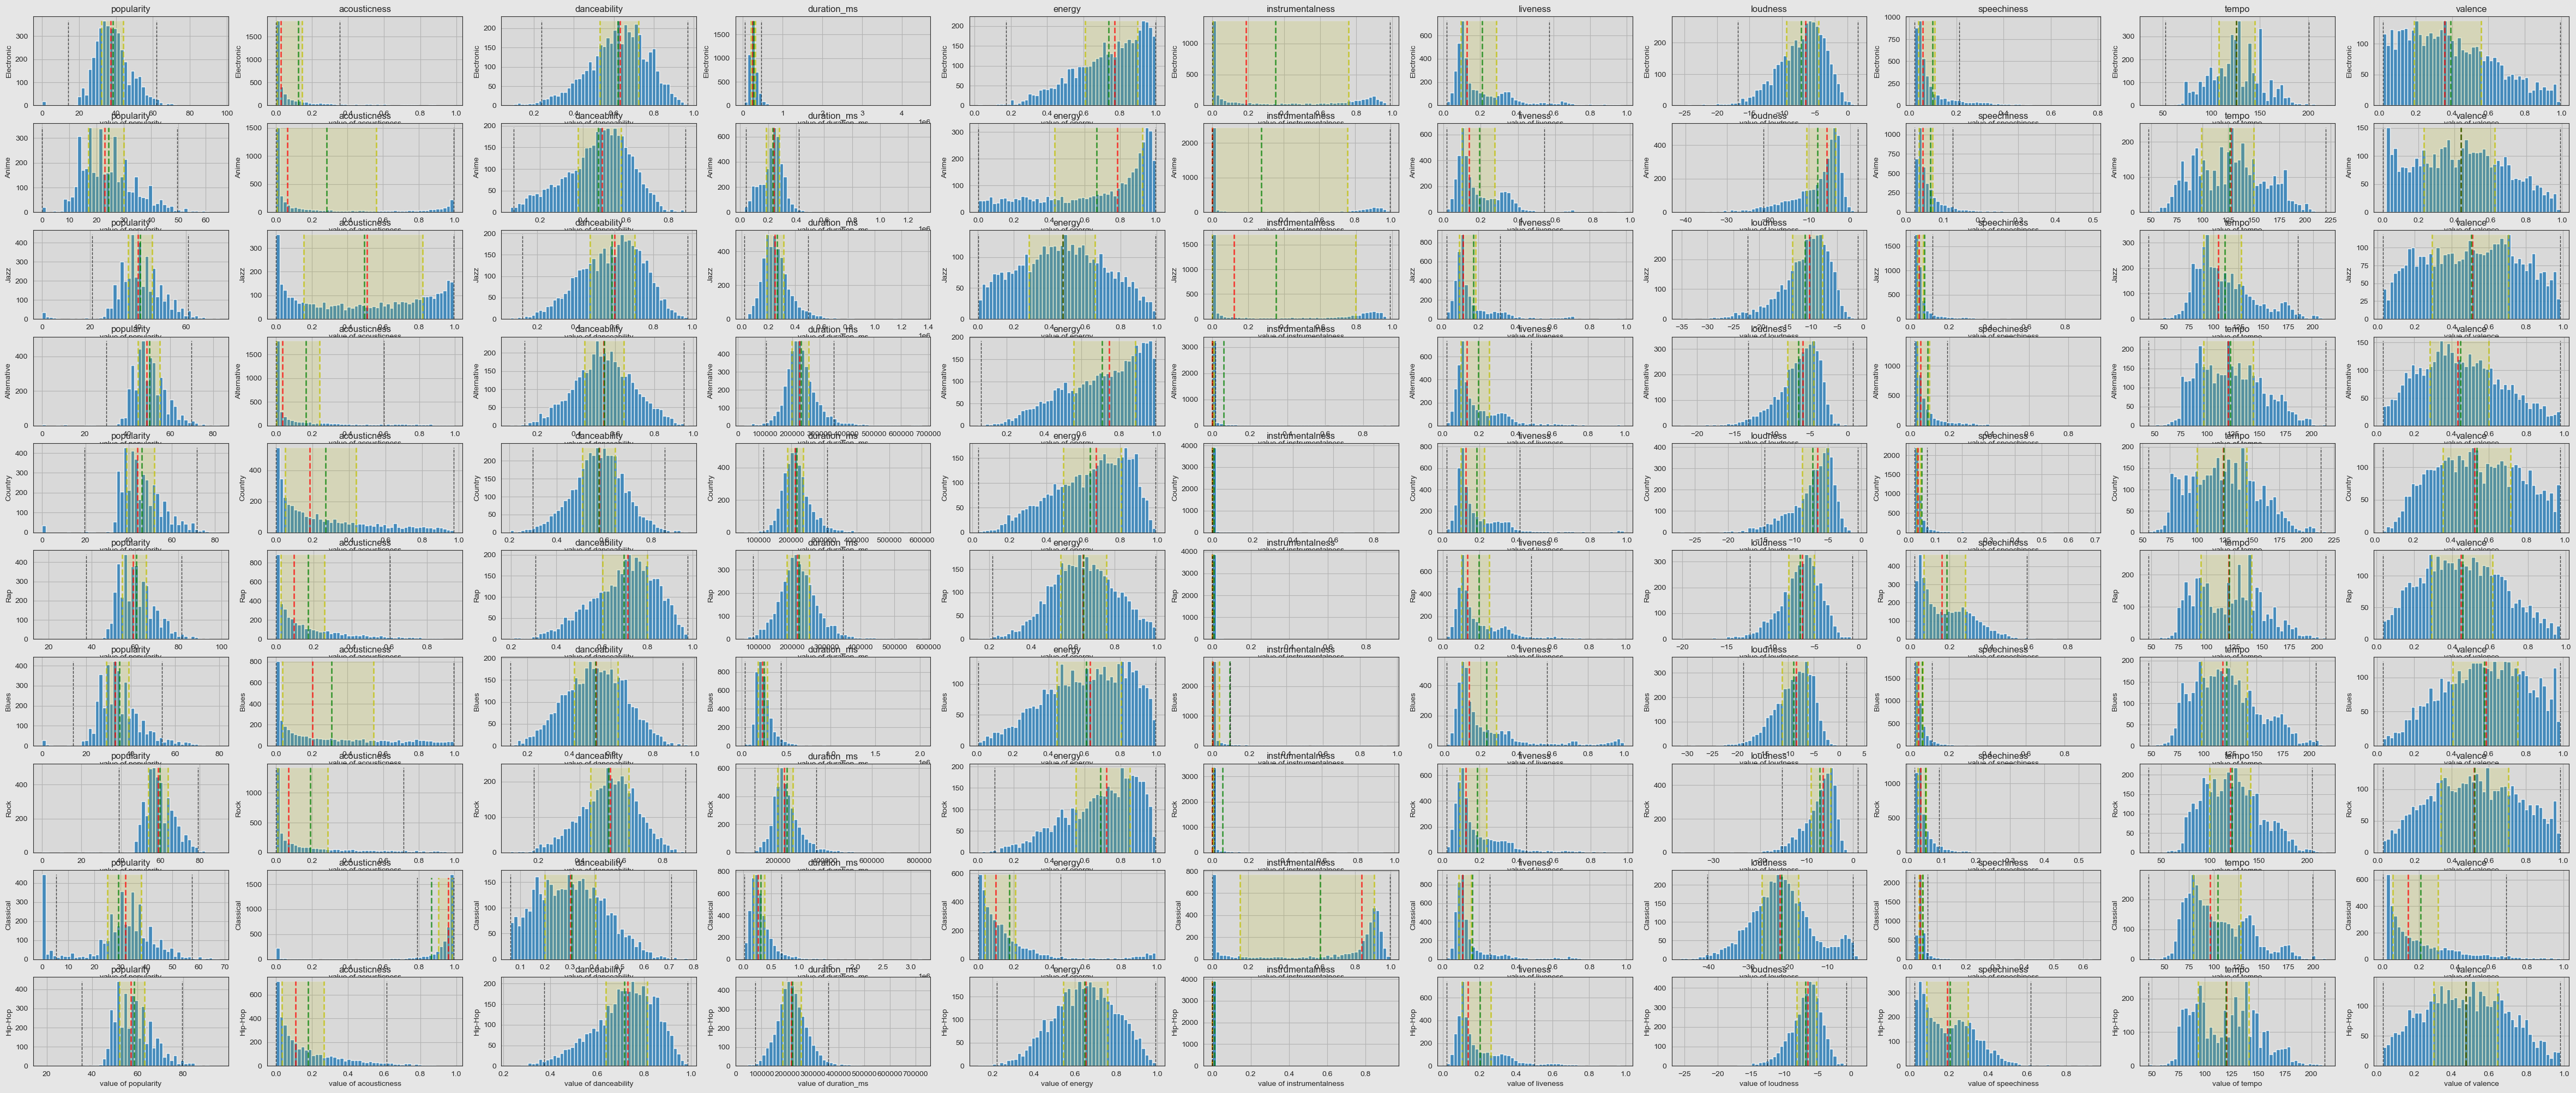

In [25]:
plt.figure(figsize=(600, 600))

i = 1
for column_cls in data_clean[target].unique():
    for column_num in number_columns:
        plt.subplot(data_clean[target].nunique(), len(number_columns), i)
        draw_gist2(data_clean[data_clean[target] == column_cls],
                   column_num,
                   bins = 50,
                   figsize = [60, 25],
                   alpha = 0.8,
                   legend = False,
                   display_desc = False)
        plt.ylabel(column_cls)
        i += 1
plt.show()

Как видно из диаграммы, проследить четкие отличия между музыкальными жанрами сложно. В большинстве случаев распределения признаков схожи, пересекаются, имеют сопоставимые характеристики.

Отобразим корреляцию Пирсона для числовых признаков

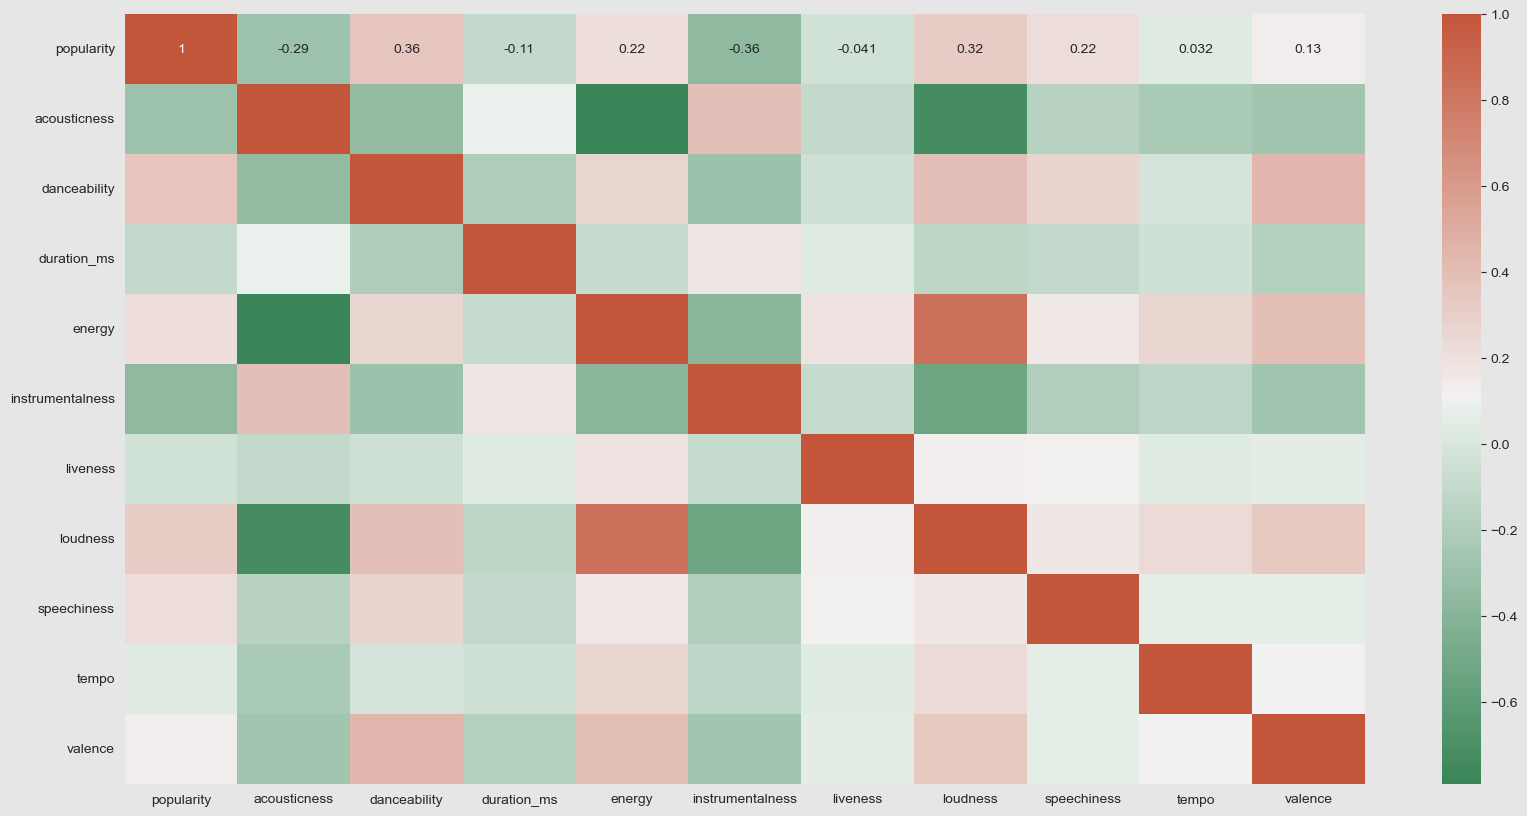

In [26]:
plt.figure(figsize=(20, 10))
cmap = sns.diverging_palette(500, 20, as_cmap=True)
sns.heatmap(data_clean[number_columns].corr(method='pearson'), annot=True, cmap=cmap)
plt.show()

Наблюдаем отрицательную корреляцию между признаком acousticness и признаками energy и loudness, также есть положительная корреляция между признаками energy и loudness.

Отобразим матрицу phik-корреляциия для всех признаков и целевой переменной

In [27]:
data_clean[number_columns + cat_columns + [target]].phik_matrix().style.background_gradient('coolwarm')

interval columns not set, guessing: ['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']


Подвердилась корреляция между признаком acousticness и признаками energy и loudness, также имеем сильную корреляцию между признаками energy и loudness.  
С таргетом сильно коррелируют признаки popularity, energy, loudness, acousticness, danceability.  

Посмотрим на распределение целевой переменной

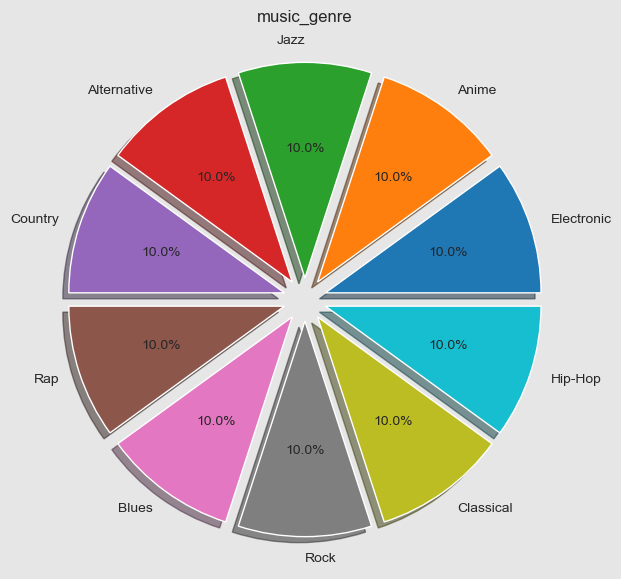

In [28]:
plt.figure(figsize=(7, 7))

freq = data[target].value_counts()
plt.pie(x=freq.values, labels=freq.index, autopct='%1.1f%%',
        explode=np.ones(freq.shape[0])*0.1, shadow=True,)
plt.title(target)

plt.show()

### Подготовим данные к обучению

Из исходного датасета удалим столбцы instance_id, artist_name, track_name, obtained_date за отсутствием информативности. Некорректные значения в признаках tempo и duration_ms заполним соответствующими медианными значениями для каждого класса таргета.

Разделим датасет на тренировочную, валидационную и тестовую выборки

In [29]:
prep_data = data.drop(['instance_id', 'artist_name', 'track_name', 'obtained_date'], axis=1)

prep_data_train, prep_data_test = train_test_split(prep_data, test_size=0.1, random_state=RANDOM_STATE)
prep_data_train, prep_data_valid = train_test_split(prep_data_train, test_size=0.11111, random_state=RANDOM_STATE)

prep_data_train.shape, prep_data_valid.shape, prep_data_test.shape

((40000, 14), (5000, 14), (5000, 14))

Некорректные значения в столбцах tempo и duration_ms заполним медианными значениями для каждого класса целевой переменной соответственно.

In [30]:
def fill_median(X:pd.DataFrame, 
                X_train:pd.DataFrame, 
                y:str, 
                column:str, 
                value:{int, float, None}):
    """Fill in the incorrect values in the dataset column with the median values 
    for each class of the target variable calculated on the training dataset.
    
    :param X: the dataset in which we correct the values
    :type X: pd.DataFrame
    :param X_train: the dataset from which we get the median values
    :type X_train: pd.DataFrame
    :param y: target variable
    :type y: str
    :param column: the column in which we correct the values
    :type column: str
    :param value: invalid value
    :type value: None, int, float

    :rtype: pd.DataFrame
    return: new new dataset with corrected values
    """

    X_clean = X_train[~(X_train[column] == value)]
    
    column_median = X_clean.pivot_table(index = y,
                                        values = column,
                                        aggfunc = 'median')

    X.loc[X[column] == value, column] = \
    X.loc[X[column] == value, [column, y]].\
    apply(lambda x: column_median.loc[x[y]].values[0], axis=1)

    return X

In [31]:
for dataset in [prep_data_train, prep_data_valid, prep_data_test]:
    
    dataset = fill_median(dataset,
                          prep_data_train,
                          target, 
                          'tempo', 
                          0)
    
    dataset = fill_median(dataset,
                          prep_data_train,
                          target, 
                          'duration_ms', 
                          -1)

Выделим признаковое описание и таргет для каждого датасета

In [32]:
X_train = prep_data_train.drop(target, axis=1)
y_train = prep_data_train[target]

X_valid = prep_data_valid.drop(target, axis=1)
y_valid = prep_data_valid[target]

X_test = prep_data_test.drop(target, axis=1)
y_test = prep_data_test[target]

Для кодирования целевой переменной будем использовать порядковое кодирование

In [33]:
unique_genres = sorted(y_train.unique())

y_train = np.array([unique_genres.index(g) for g in y_train])
y_valid = np.array([unique_genres.index(g) for g in y_valid])
y_test = np.array([unique_genres.index(g) for g in y_test])

### Выводы по этапу:  

- Были удалены 5 пустых записей из датасета;
- Некорректные значения в столбах tempo, duration_ms были заменены на медианные значения для каждого соответствующего класса целевой переменной;
- Дубликатов в датасете не было обнаружено;
- У категориальных признаков не было обнарудено некорретных значений и пропусков;  
- У признаков duration_ms, instrumentalness, liveness, loudness, speechiness были обнаружены выбросы, соответствующие записи не были удалены из датасета, поскольку мы не можем исключать наличие музыкальных треков с нестандартными характеристиками;  
- Из исследовательского анализа был сделан вывод, что музыкальный жанр classical наибольшим образом отличается от других по имееющиимуся признаковому описанию;  
- Остальные жанры имееют схожие распределения признаков, и проследить явные отличия в них затруднительно;  
- Исследование корреляции Пирсона показало наличие отрицательной корреляции между признаком acousticness и признаками energy и loudness и также положительной корреляции между energy и loudness;  
- Исследование phik-корреляции показало достаточно сильную зависимость целевой переменной от признаков popularity, energy, loudness, acousticness, danceability;  
- Целевая переменная является сбалансированной, доли всех классов одинаковы;
- Признаки instance_id, artist_name, track_name, obtained_date были удалены из датасета, поскольку не несет никакой информации об характеристиках музыкального произведения;  
- Датасет был разделен на тренировочную, валидационную и тестовую выборки в соотношении 8\1\1 соответственно;  
- Для преобразования целевой переменной использовали порядковое кодирование.

## Исследование моделей

Исследовать будем следующие модели:  
- линейная регрессия,  
- случайный лес,  
- градиентный бустинг.

Сравнивать качество моделей будем по метрике f1-macro на валидационной выборке.  
Перед обучением моделей закодируем категориальные признаки и отмасштабируем числовые.  

Напишем функции для обучения и тестирования моделей

In [34]:
# функция построения ROC кривой для мултиклассовой классификации
def draw_roc_for_multiclass(y:np.ndarray, 
                            y_dense:np.ndarray, 
                            y_pred:np.ndarray, 
                            y_pred_prob:np.ndarray,
                            classes_name:list, 
                            step:str='valid'):
    """
    To construct a ROC curve based on the prediction 
    results from solving a multiclass classification problem.
    """
    
    accuracy = accuracy_score(y, y_pred) #посчитаем точность предсказания
 
    #определим необходимые переменные
    n_classes = len(classes_name) #число классов
    fpr = dict()  #False Positive Rate
    tpr = dict()  #True Positive Rate
    roc_auc = dict() 
    lw=2

    #рассчитаем значения roc кривой для каждого класса
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_dense[:, i], y_pred_prob[:, i])
        roc_auc[i] = roc_auc_score(y_dense[:, i], y_pred_prob[:, i])

    #построим графики roc кривых
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw=lw,
                 label='ROC AUC score of class {0} (area = {1:0.2f})'
                 ''.format(classes_name[i], roc_auc[i]))
            
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)

    plt.text(0.65, 0.42, f'accuracy on {step} = {round(accuracy, 3)}',
                 fontsize=12,
                 bbox={'facecolor': 'white', 'edgecolor': 'black',
                       'alpha': 0.2, 'pad': 10})
    
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC for {step} data')
    plt.legend(loc="lower right")

    return roc_auc

# функция построения precision-recall кривой для мультиклассовой классификации
def draw_prc_for_multiclass(y_dense:np.ndarray, 
                            y_pred_prob:np.ndarray, 
                            y_pred_dense:np.ndarray,
                            classes_name:list, 
                            step:str='valid'):
    """
    To construct a precision-recall curve based on the prediction 
    results from solving a multiclass classification problem.
    """

    n_classes = len(classes_name)

    pvl = dict() #Precision
    rvl = dict() #Recall
    f1 = dict() #f1 score
    lw=2

    # рассчитаем значения p-r кривой и f1 для каждого класса  
    for i in range(n_classes):
        pvl[i], rvl[i], _ = precision_recall_curve(y_dense[:, i],
                                                   y_pred_prob[:, i])
        f1[i] = f1_score(y_dense[:, i], y_pred_dense[:, i])

    # построим p-r кривую для каждого класса
    for i in range(n_classes):
        plt.plot(pvl[i], rvl[i], lw=2,
                 label='f1 score of class {0} (area = {1:0.2f})'
                 ''.format(classes_name[i], f1[i]))

    plt.title(f'Precision - Recall curve for {step} data')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()

    return f1

# функция тестирования модели
def check_model(model, 
                X_valid:pd.DataFrame, 
                y_valid:np.ndarray, 
                classes_name:list,
                figsize:tuple=(20, 10)):
    """
    Test the model on validation data.
    """

    y_pred_val = model.predict(X_valid)
    y_pred_prob_val = model.predict_proba(X_valid)
    cls_rep_val = classification_report(y_valid, y_pred_val)

    binarizer = LabelBinarizer()
    y_valid_dense = binarizer.fit_transform(y_valid)
    y_pred_val_dense = binarizer.transform(y_pred_val)

    print('classification report on valid \n', cls_rep_val)

    plt.figure(figsize=figsize)

    plt.subplot(1, 2, 1)
    draw_roc_for_multiclass(y_valid, y_valid_dense, y_pred_val,
                            y_pred_prob_val, classes_name,
                            step='valid')

    plt.subplot(1, 2, 2)
    draw_prc_for_multiclass(y_valid_dense, y_pred_prob_val,
                            y_pred_val_dense, classes_name,
                            step='valid')

    plt.show()

# функция обучения модели
def fit_model(model, 
              params:dict, 
              scoring:str,
              X_train:pd.DataFrame, 
              X_valid:pd.DataFrame, 
              y_train:np.ndarray, 
              y_valid:np.ndarray,
              classes_name: list, 
              cv:int=5, 
              random_state:bool=False):
    """
    Fit a model on training data and test it on
    validation data.
    """

    #Определим модель
    if random_state:
        est_model = RandomizedSearchCV(model,
                                       params,
                                       n_iter=30,
                                       cv=cv,
                                       verbose=5,
                                       random_state=random_state,
                                       scoring=scoring,
                                       n_jobs=-1)
    else:
        est_model = GridSearchCV(model,
                                 params,
                                 cv=cv,
                                 verbose=5,
                                 scoring=scoring,
                                 n_jobs=-1)

    #Обучим модель
    est_model.fit(X_train, y_train)

    #Выведим на экран лучший score и лучшие гиперпараметры
    print('best score:', est_model.best_score_)
    print('best parametrs:', est_model.best_params_)

    #Сохраним лучшую модель
    best_model = est_model.best_estimator_

    check_model(best_model, X_valid, y_valid, classes_name)

    return best_model

#Функция получения предсказания для тестового датасета
def test_model(model, 
               X_test:pd.DataFrame,
               genres_name:list):
    """
    Get model predictions based on test data.
    """
    
    pred = model.predict(X_test)
    pred = np.reshape(pred, (pred.shape[0]))
    pred = [genres_name[g] for g in pred]

    return pred

### Логистическая регрессия

Подберем гиперпараметры и обучим модель логистической регрессии

In [37]:
params_LR = {
    'clf': [LogisticRegression()],
    'clf__C': [1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001],
    'clf__penalty': ['l2'],
    'clf__solver': ['lbfgs', 'newton-cg', 'sag', 'saga']
}

num_pipeline = make_imblearn_pipeline(StandardScaler())

column_transformer = make_column_transformer((num_pipeline, number_columns),
                                              (OneHotEncoder(drop='first', sparse=False), cat_columns),
                                              remainder='passthrough')

pipeline = make_imblearn_pipeline(column_transformer,
                                  LogisticRegression())

pipeline.steps[-1] = ('clf', pipeline.steps[-1][1])
pipeline.named_steps

{'columntransformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('pipeline',
                                  Pipeline(steps=[('standardscaler',
                                                   StandardScaler())]),
                                  ['popularity', 'acousticness', 'danceability',
                                   'duration_ms', 'energy', 'instrumentalness',
                                   'liveness', 'loudness', 'speechiness',
                                   'tempo', 'valence']),
                                 ('onehotencoder',
                                  OneHotEncoder(drop='first', sparse=False),
                                  ['key', 'mode'])]),
 'clf': LogisticRegression()}

Fitting 5 folds for each of 28 candidates, totalling 140 fits
best score: 0.5259153220604624
best parametrs: {'clf': LogisticRegression(), 'clf__C': 1, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
classification report on valid 
               precision    recall  f1-score   support

           0       0.41      0.30      0.35       529
           1       0.64      0.62      0.63       490
           2       0.51      0.47      0.49       502
           3       0.80      0.80      0.80       536
           4       0.49      0.55      0.52       521
           5       0.53      0.61      0.57       433
           6       0.45      0.50      0.47       511
           7       0.50      0.42      0.46       517
           8       0.45      0.38      0.41       500
           9       0.47      0.66      0.55       461

    accuracy                           0.53      5000
   macro avg       0.53      0.53      0.52      5000
weighted avg       0.53      0.53      0.52      5000



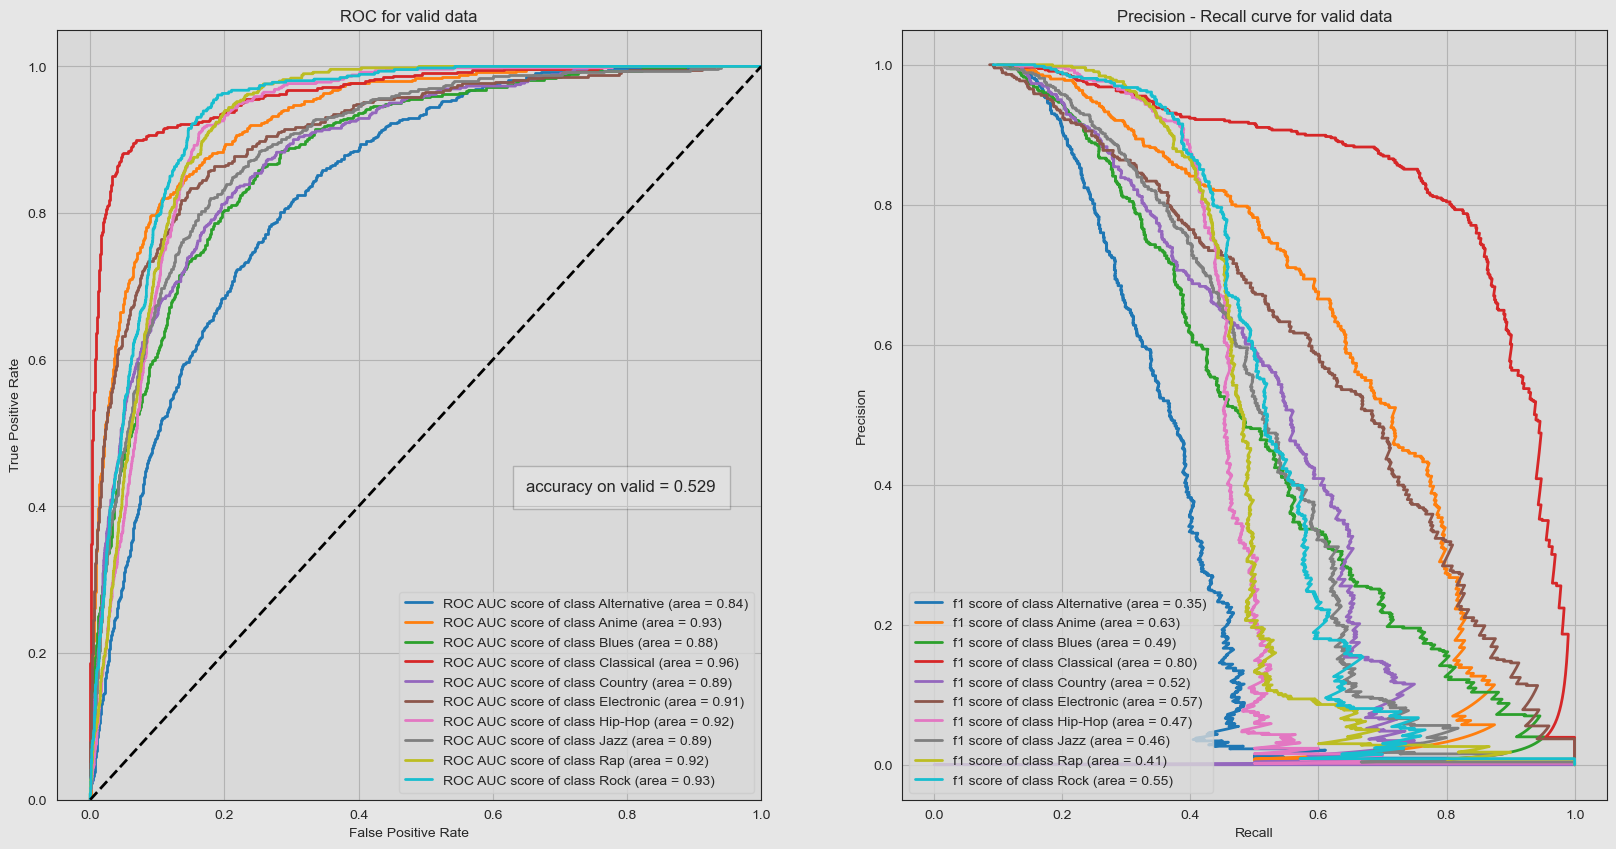

In [38]:
model_LR = fit_model(pipeline, params_LR, 'f1_macro',
                      X_train, X_valid, y_train, y_valid,
                      unique_genres, cv=5)

Значение метрики f1-macro = 0.52 на валидационной выборке.  
Оставим лучшие гиперпараметры и попробуем подобрать оптимальный метод шкалирования числовых признаков.

In [39]:
params_LR = {
    'clf': [LogisticRegression()],
    'clf__C': [1],
    'clf__penalty': ['l2'],
    'clf__solver': ['lbfgs'],
    'columntransformer__pipeline__standardscaler': [StandardScaler(), RobustScaler(), 
                                                    Normalizer(), MinMaxScaler()]
}

num_pipeline = make_imblearn_pipeline(StandardScaler())

column_transformer = make_column_transformer((num_pipeline, number_columns),
                                              (OneHotEncoder(drop='first', sparse=False), cat_columns),
                                              remainder='passthrough')

pipeline = make_imblearn_pipeline(column_transformer,
                                  LogisticRegression())

pipeline.steps[-1] = ('clf', pipeline.steps[-1][1])
pipeline.named_steps

{'columntransformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('pipeline',
                                  Pipeline(steps=[('standardscaler',
                                                   StandardScaler())]),
                                  ['popularity', 'acousticness', 'danceability',
                                   'duration_ms', 'energy', 'instrumentalness',
                                   'liveness', 'loudness', 'speechiness',
                                   'tempo', 'valence']),
                                 ('onehotencoder',
                                  OneHotEncoder(drop='first', sparse=False),
                                  ['key', 'mode'])]),
 'clf': LogisticRegression()}

Fitting 5 folds for each of 4 candidates, totalling 20 fits
best score: 0.5259723748341317
best parametrs: {'clf': LogisticRegression(), 'clf__C': 1, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs', 'columntransformer__pipeline__standardscaler': RobustScaler()}
classification report on valid 
               precision    recall  f1-score   support

           0       0.41      0.30      0.35       529
           1       0.64      0.62      0.63       490
           2       0.51      0.47      0.49       502
           3       0.79      0.80      0.80       536
           4       0.49      0.55      0.52       521
           5       0.53      0.61      0.57       433
           6       0.45      0.49      0.47       511
           7       0.50      0.41      0.45       517
           8       0.45      0.38      0.42       500
           9       0.47      0.66      0.55       461

    accuracy                           0.53      5000
   macro avg       0.53      0.53      0.52      5000
weig

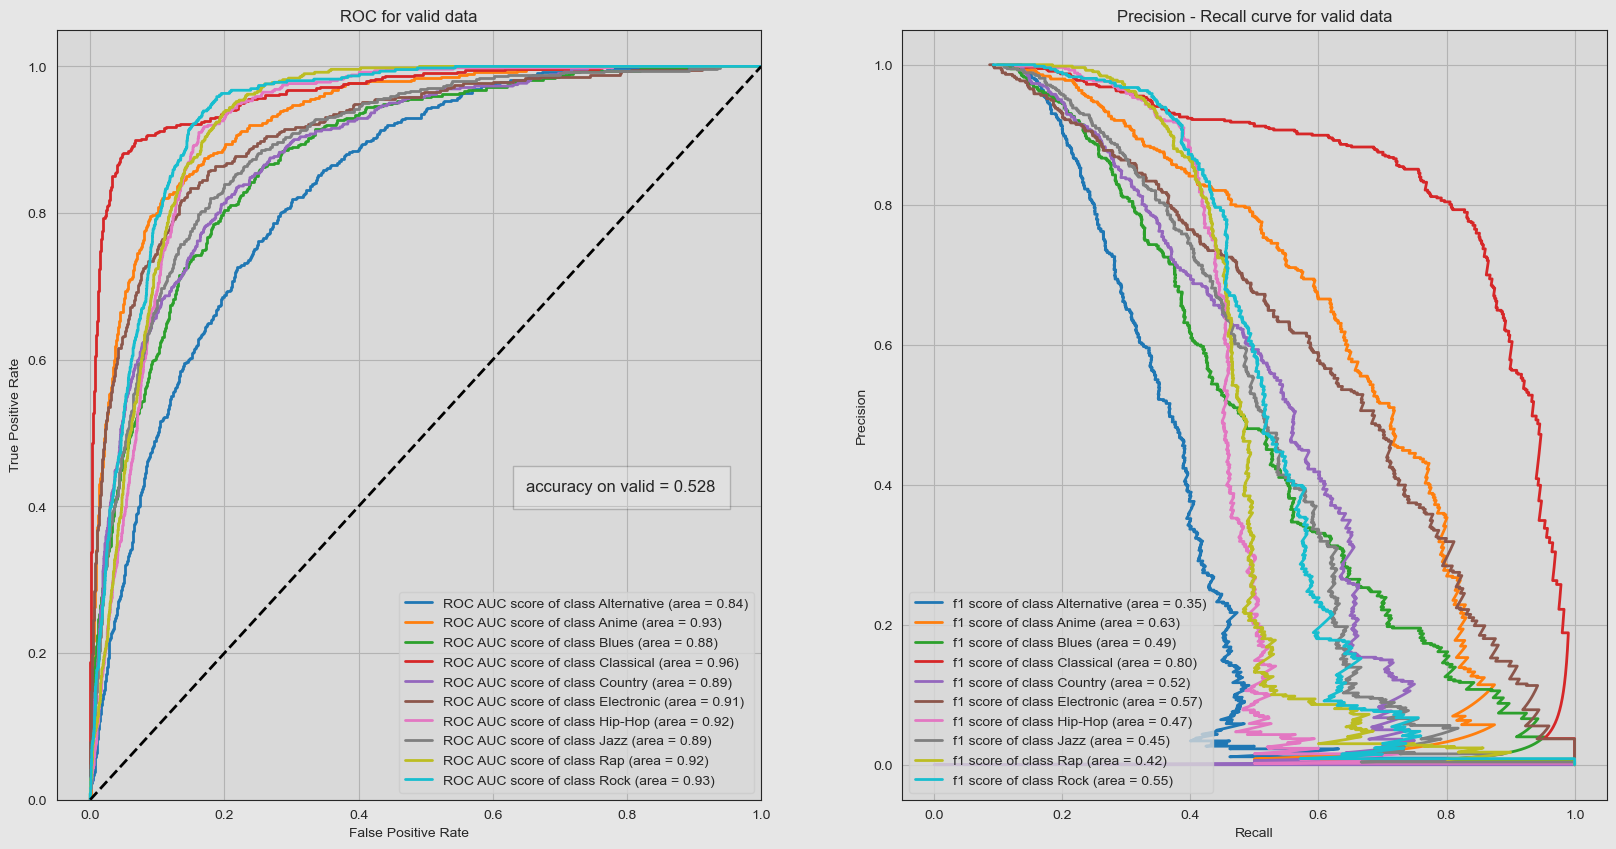

In [40]:
model_LR_2 = fit_model(pipeline, params_LR, 'f1_macro',
                       X_train, X_valid, y_train, y_valid,
                       unique_genres, cv=5)

Оптимальным методом шкаоирования является RobustScaler.  
Теперь добавим в pipeline генерация новых числовых признаков на основе возведения их в степень с последующим отсеиванием признаков с высокой степенью корреляции. Также добавим в pipeline метод SMOTETomek.

In [43]:
params_LR = {
    'clf': [LogisticRegression()],
    'clf__C': [1],
    'clf__penalty': ['l2'],
    'clf__solver': ['lbfgs'],
    'columntransformer__pipeline__standardscaler': [RobustScaler()],
    'columntransformer__pipeline__dropcorrelatedfeatures__threshold': [0.8, 0.9]
}

num_pipeline = make_imblearn_pipeline(StandardScaler(), PolynomialFeatures(),
                                      DropCorrelatedFeatures(threshold=0.9),
                                      DropConstantFeatures())

column_transformer = make_column_transformer((num_pipeline, number_columns),
                                              (OneHotEncoder(drop='first', sparse=False), cat_columns),
                                              remainder='passthrough')

pipeline = make_imblearn_pipeline(column_transformer,
                                  SMOTETomek(),
                                  LogisticRegression())

pipeline.steps[-1] = ('clf', pipeline.steps[-1][1])
pipeline.named_steps

{'columntransformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('pipeline',
                                  Pipeline(steps=[('standardscaler',
                                                   StandardScaler()),
                                                  ('polynomialfeatures',
                                                   PolynomialFeatures()),
                                                  ('dropcorrelatedfeatures',
                                                   DropCorrelatedFeatures(threshold=0.9)),
                                                  ('dropconstantfeatures',
                                                   DropConstantFeatures())]),
                                  ['popularity', 'acousticness', 'danceability',
                                   'duration_ms', 'energy', 'instrumentalness',
                                   'liveness', 'loudness', 'speechiness',
                                   'tempo', 'va

Fitting 5 folds for each of 2 candidates, totalling 10 fits
best score: 0.5494742350472598
best parametrs: {'clf': LogisticRegression(), 'clf__C': 1, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs', 'columntransformer__pipeline__dropcorrelatedfeatures__threshold': 0.9, 'columntransformer__pipeline__standardscaler': RobustScaler()}
classification report on valid 
               precision    recall  f1-score   support

           0       0.44      0.37      0.40       529
           1       0.69      0.69      0.69       490
           2       0.60      0.50      0.54       502
           3       0.82      0.81      0.81       536
           4       0.52      0.59      0.55       521
           5       0.58      0.62      0.60       433
           6       0.46      0.56      0.51       511
           7       0.53      0.50      0.51       517
           8       0.45      0.34      0.39       500
           9       0.48      0.61      0.54       461

    accuracy                           0.

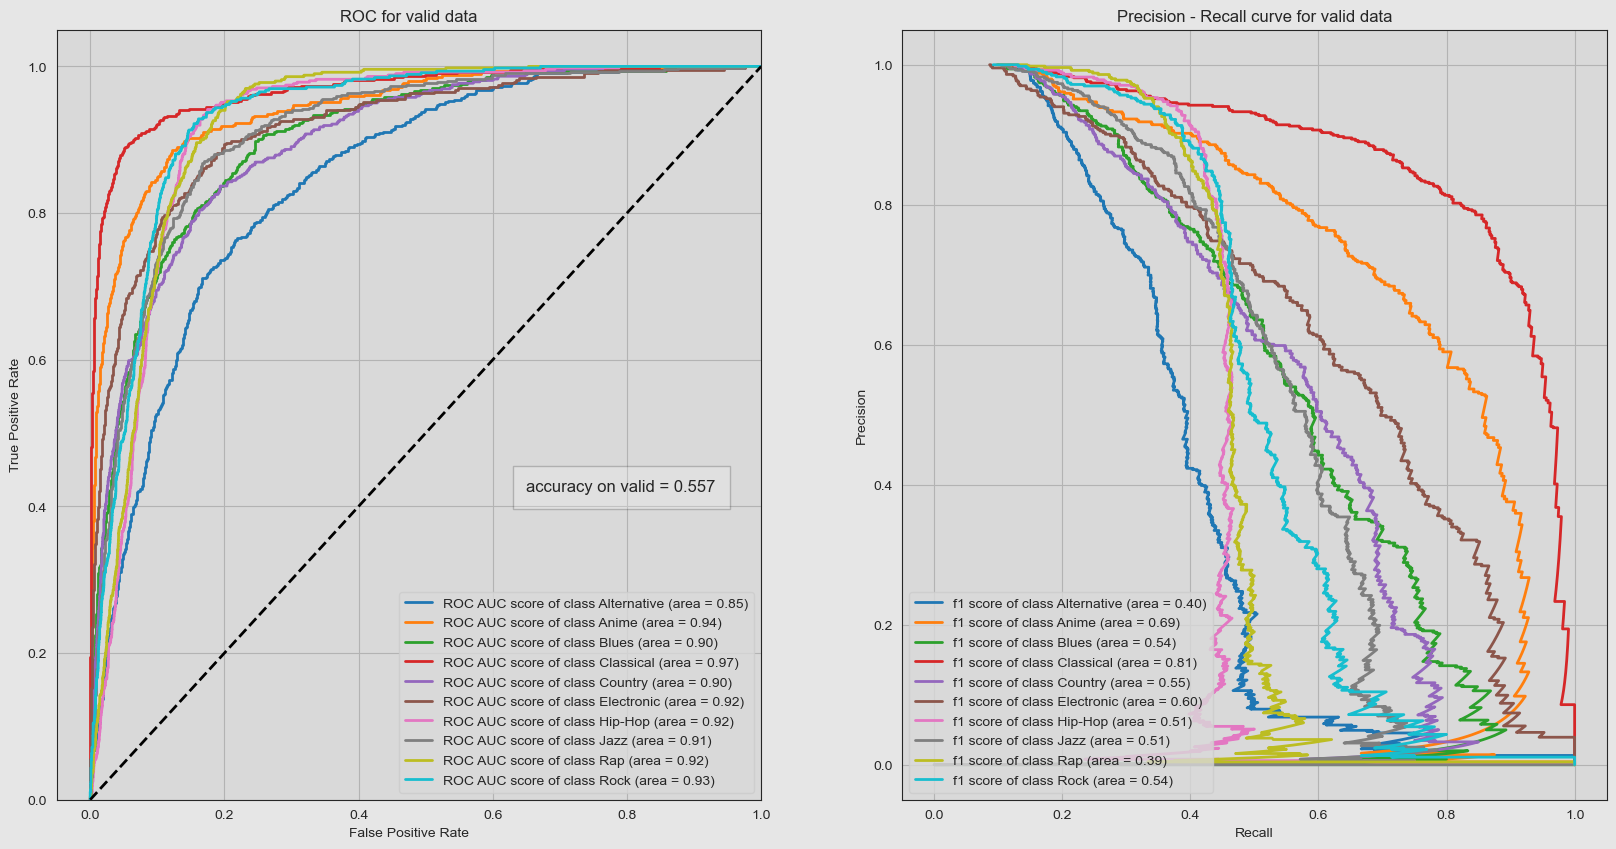

In [44]:
model_LR_3 = fit_model(pipeline, params_LR, 'f1_macro',
                       X_train, X_valid, y_train, y_valid,
                       unique_genres, cv=5)

Модель логистической регрессии достигла значение метрики f1-macro на валидации 0.55.  
Оптимальные гиперпараметры модели:  С = 1, penalty = l2, solver = lbfgs.  
Для шкалирования числовых признаков применялся RobustScaler.  
Также в pipeline были включены метод генерации числовых признаков на основе возведения в степень, удаление признаков с высокой степенью корреляции и константные признаки, метод SMOTETomek для улучшения разделимости классов. 

### Случайный Лес

Обучим модель случайного леса и подберем оптимальные гиперпараметры.

Fitting 5 folds for each of 168 candidates, totalling 840 fits
best score: 0.5814344664763814
best parametrs: {'clf': RandomForestClassifier(), 'clf__criterion': 'gini', 'clf__max_depth': 9, 'clf__n_estimators': 512, 'columntransformer__pipeline__standardscaler': None}
classification report on valid 
               precision    recall  f1-score   support

           0       0.53      0.25      0.34       504
           1       0.73      0.71      0.72       479
           2       0.68      0.52      0.59       515
           3       0.80      0.84      0.82       454
           4       0.52      0.62      0.57       481
           5       0.64      0.64      0.64       540
           6       0.48      0.60      0.53       504
           7       0.61      0.52      0.56       532
           8       0.49      0.39      0.44       473
           9       0.49      0.82      0.61       518

    accuracy                           0.59      5000
   macro avg       0.60      0.59      0.58    

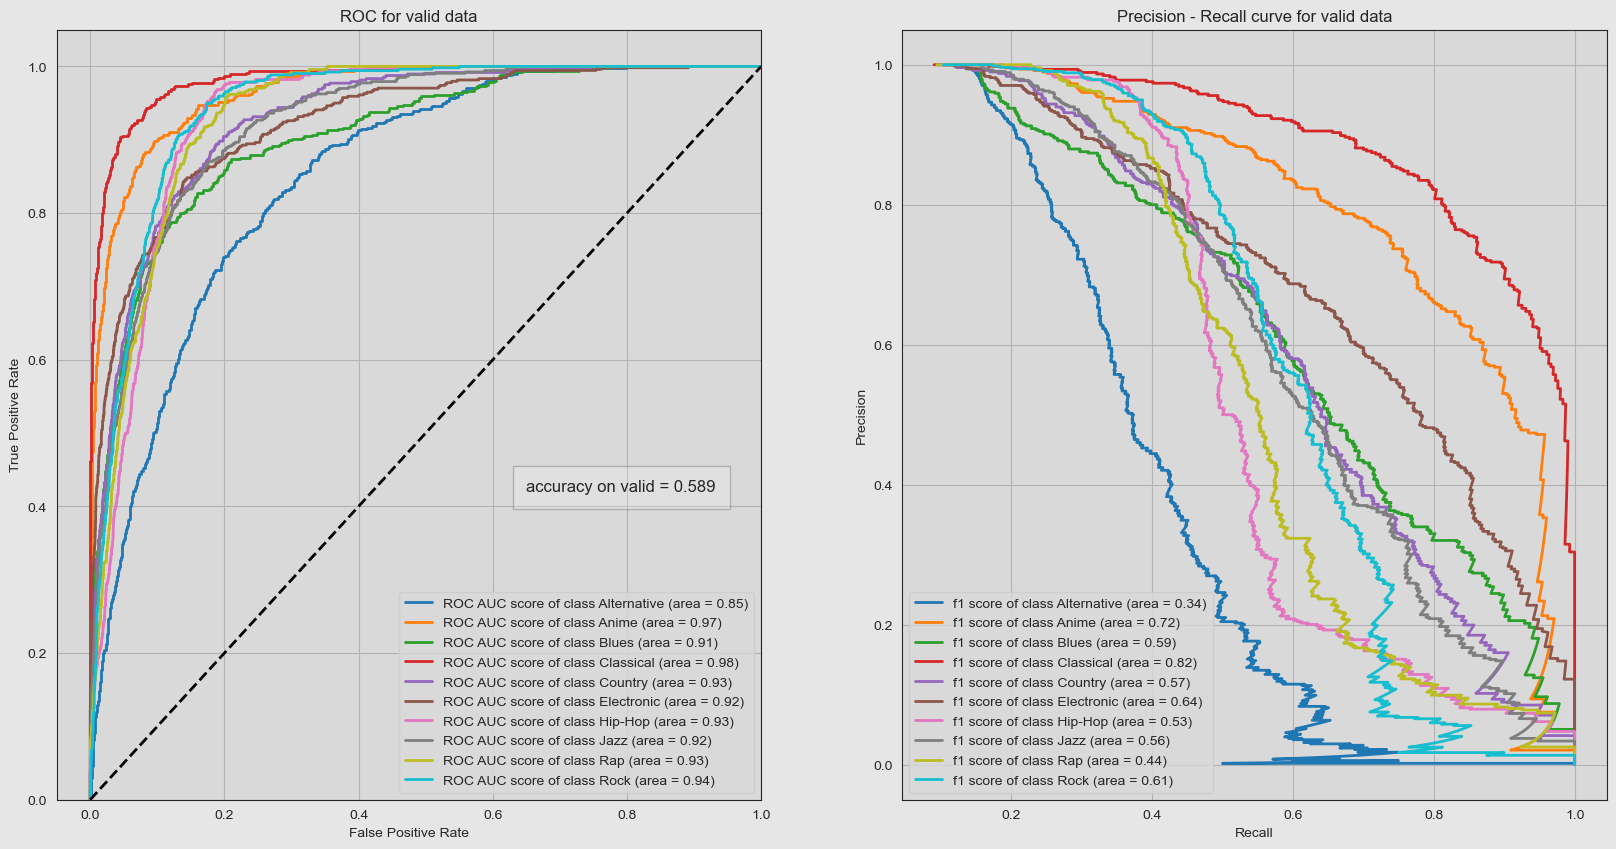

In [35]:
params_RFC = {
    'clf': [RandomForestClassifier()],
    'clf__n_estimators': [8, 16, 32, 64, 128, 256, 512],
    'clf__max_depth': range(2, 10),
    'clf__criterion': ['gini', 'entropy', 'log_loss'],
    'columntransformer__pipeline__standardscaler': [None]
}

num_pipeline = make_imblearn_pipeline(StandardScaler())

column_transformer = make_column_transformer((num_pipeline, number_columns),
                                             (OrdinalEncoder(), cat_columns),
                                             remainder='passthrough')

pipeline = make_imblearn_pipeline(column_transformer,
                                  RandomForestClassifier())

pipeline.steps[-1] = ('clf', pipeline.steps[-1][1])
pipeline.named_steps

model_RF_1 = fit_model(pipeline, params_RFC, 'f1_macro',
                       X_train, X_valid, y_train, y_valid,
                       unique_genres, cv=5)

Случайный лес с оптимальными гиперпараметрами на валидационной выборке показал значение метрики f1-macro равное 0.58.  
Попробуем подобрать оптимальный шкалер.

Fitting 5 folds for each of 5 candidates, totalling 25 fits
best score: 0.581890844022376
best parametrs: {'clf': RandomForestClassifier(), 'clf__criterion': 'gini', 'clf__max_depth': 9, 'clf__n_estimators': 512, 'columntransformer__pipeline__standardscaler': RobustScaler()}
classification report on valid 
               precision    recall  f1-score   support

           0       0.51      0.24      0.33       504
           1       0.74      0.71      0.72       479
           2       0.67      0.50      0.57       515
           3       0.80      0.84      0.82       454
           4       0.52      0.62      0.57       481
           5       0.64      0.65      0.64       540
           6       0.48      0.60      0.53       504
           7       0.60      0.52      0.56       532
           8       0.49      0.39      0.43       473
           9       0.49      0.82      0.62       518

    accuracy                           0.59      5000
   macro avg       0.59      0.59      0.

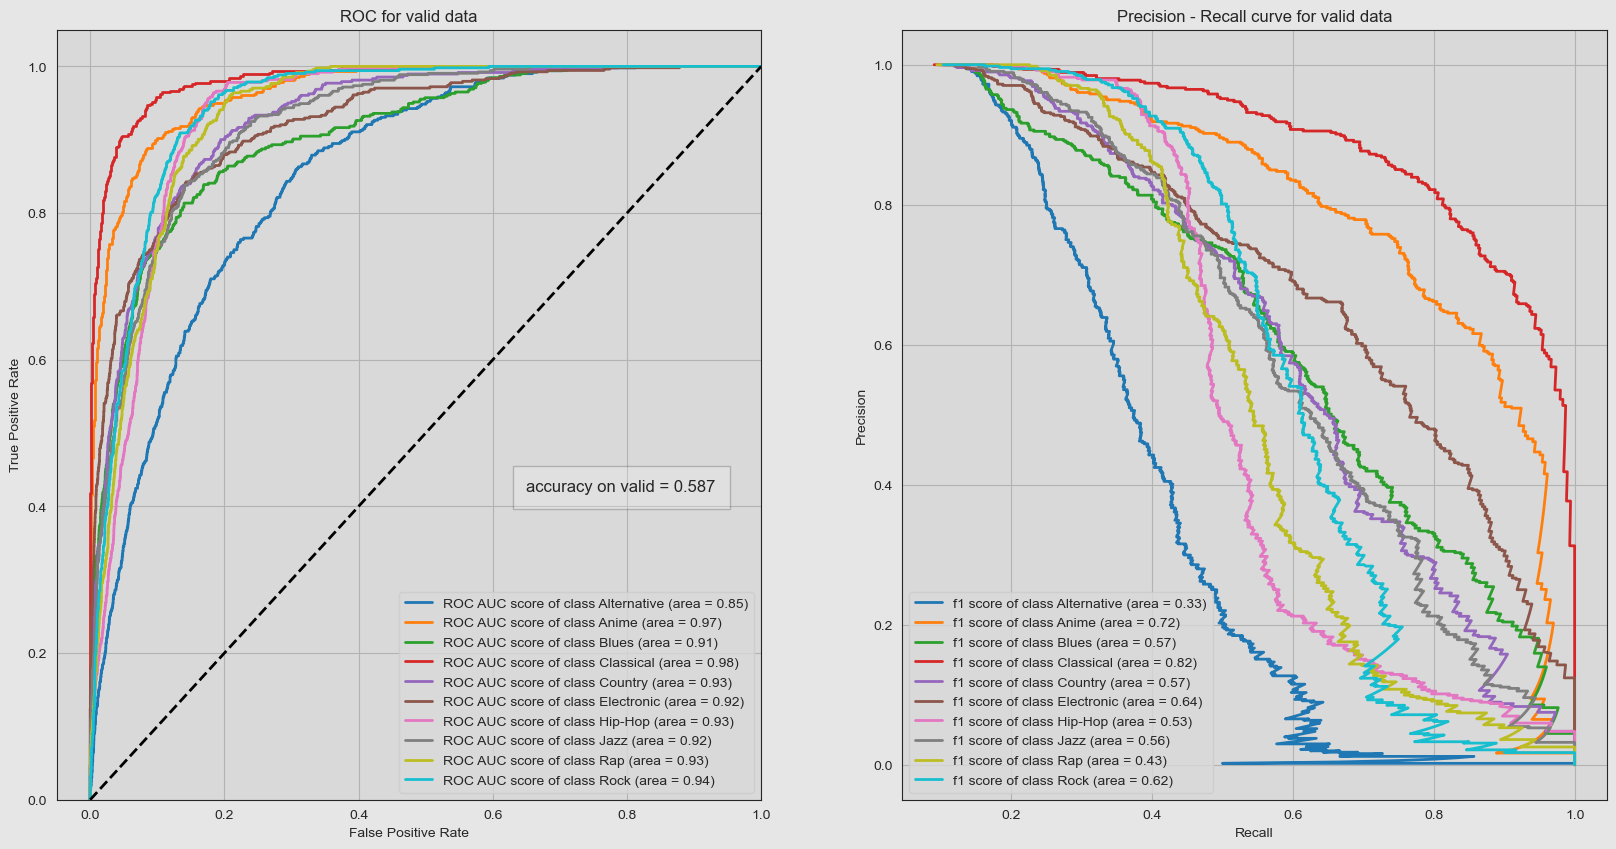

In [36]:
params_RFC = {
    'clf': [RandomForestClassifier()],
    'clf__n_estimators': [512],
    'clf__max_depth': [9],
    'clf__criterion': ['gini'],
    'columntransformer__pipeline__standardscaler': [None, StandardScaler(), RobustScaler(), 
                                                    Normalizer(), MinMaxScaler()]
}

num_pipeline = make_imblearn_pipeline(StandardScaler())

column_transformer = make_column_transformer((num_pipeline, number_columns),
                                             (OrdinalEncoder(), cat_columns),
                                             remainder='passthrough')

pipeline = make_imblearn_pipeline(column_transformer,
                                  RandomForestClassifier())

pipeline.steps[-1] = ('clf', pipeline.steps[-1][1])
pipeline.named_steps

model_RF_2 = fit_model(pipeline, params_RFC, 'f1_macro',
                       X_train, X_valid, y_train, y_valid,
                       unique_genres, cv=5)

Оптимальным шкалером также является RobustScaler, но прирост метрики f1-macro незначителен и составляет 0.0004.  
Добавим в pipeline генерация числовых признаков и метод SMOTETomek.

In [37]:
params_RFC = {
    'clf': [RandomForestClassifier()],
    'clf__n_estimators': [512],
    'clf__max_depth': [9],
    'clf__criterion': ['gini'],
    'columntransformer__pipeline__standardscaler': [RobustScaler()],
    'columntransformer__pipeline__dropcorrelatedfeatures__threshold': [0.8, 0.9]

}

num_pipeline = make_imblearn_pipeline(StandardScaler(), PolynomialFeatures(),
                                      DropCorrelatedFeatures(threshold=0.9),
                                      DropConstantFeatures())

column_transformer = make_column_transformer((num_pipeline, number_columns),
                                             (OrdinalEncoder(), cat_columns),
                                             remainder='passthrough')

pipeline = make_imblearn_pipeline(column_transformer,
                                  SMOTETomek(),
                                  RandomForestClassifier())

pipeline.steps[-1] = ('clf', pipeline.steps[-1][1])
pipeline.named_steps

{'columntransformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('pipeline',
                                  Pipeline(steps=[('standardscaler',
                                                   StandardScaler()),
                                                  ('polynomialfeatures',
                                                   PolynomialFeatures()),
                                                  ('dropcorrelatedfeatures',
                                                   DropCorrelatedFeatures(threshold=0.9)),
                                                  ('dropconstantfeatures',
                                                   DropConstantFeatures())]),
                                  ['popularity', 'acousticness', 'danceability',
                                   'duration_ms', 'energy', 'instrumentalness',
                                   'liveness', 'loudness', 'speechiness',
                                   'tempo', 'va

Fitting 5 folds for each of 2 candidates, totalling 10 fits
best score: 0.5592702346715093
best parametrs: {'clf': RandomForestClassifier(), 'clf__criterion': 'gini', 'clf__max_depth': 9, 'clf__n_estimators': 512, 'columntransformer__pipeline__dropcorrelatedfeatures__threshold': 0.8, 'columntransformer__pipeline__standardscaler': RobustScaler()}
classification report on valid 
               precision    recall  f1-score   support

           0       0.45      0.19      0.27       504
           1       0.71      0.71      0.71       479
           2       0.65      0.47      0.54       515
           3       0.80      0.82      0.81       454
           4       0.43      0.67      0.52       481
           5       0.64      0.60      0.62       540
           6       0.48      0.59      0.53       504
           7       0.61      0.46      0.53       532
           8       0.48      0.35      0.41       473
           9       0.49      0.79      0.60       518

    accuracy           

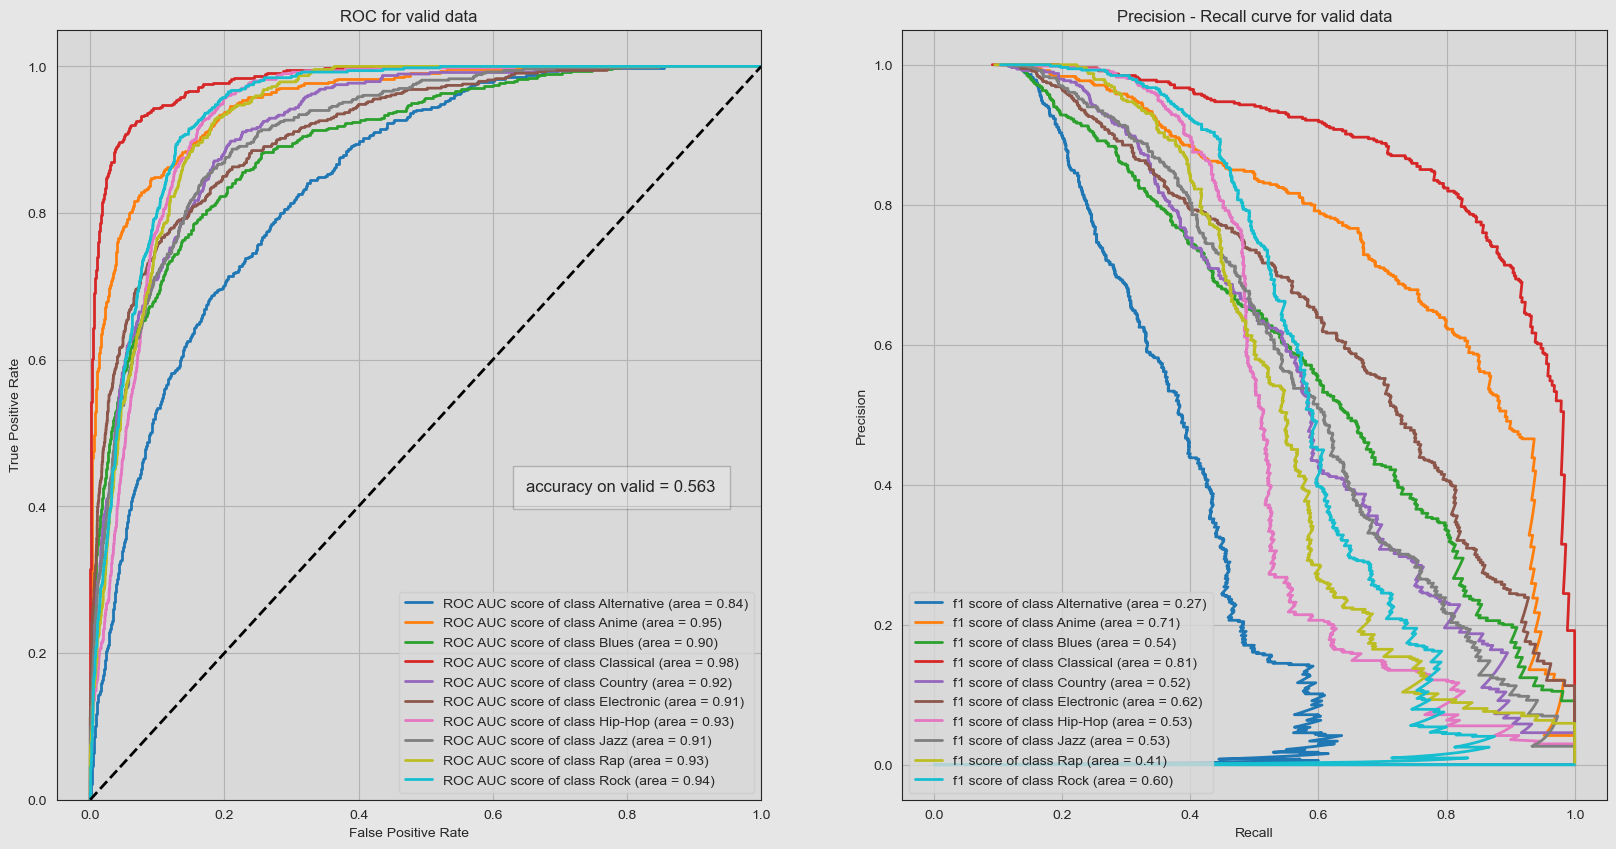

In [38]:
model_RF_3 = fit_model(pipeline, params_RFC, 'f1_macro',
                       X_train, X_valid, y_train, y_valid,
                       unique_genres, cv=5)

Для случайного леса генерация доп признаков оказало отрицательный эффект, значение метрики f1-macro снизилось.  
Таким образом оптимальным pipeline'ом для случайного леса является использование RobustScaler'a для числовых признаков и обучение на имеющихся признаках.  
Оптимальные параметры случайного леса: criterion = gini, max_depth = 9, n_estimators = 512.

### Градиентный бустинг

Обучим и подберем оптимальные гиперпараметры для модели градиентного бустинга

In [38]:
params_GB = {
    'n_estimators': [32, 64, 128, 256, 512],
    'max_depth': range(4, 10),
    'l2_leaf_reg': [0.01, 0.05, 0.1]
}

model_GB = cb.CatBoostClassifier(cat_features = cat_columns)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
0:	learn: 2.2371544	total: 326ms	remaining: 2m 46s
1:	learn: 2.1789264	total: 466ms	remaining: 1m 58s
2:	learn: 2.1273939	total: 607ms	remaining: 1m 43s
3:	learn: 2.0815278	total: 741ms	remaining: 1m 34s
4:	learn: 2.0371771	total: 892ms	remaining: 1m 30s
5:	learn: 2.0004163	total: 1.02s	remaining: 1m 26s
6:	learn: 1.9637655	total: 1.17s	remaining: 1m 24s
7:	learn: 1.9306155	total: 1.33s	remaining: 1m 23s
8:	learn: 1.8984633	total: 1.49s	remaining: 1m 22s
9:	learn: 1.8688587	total: 1.62s	remaining: 1m 21s
10:	learn: 1.8414534	total: 1.75s	remaining: 1m 19s
11:	learn: 1.8158489	total: 1.88s	remaining: 1m 18s
12:	learn: 1.7909545	total: 2.01s	remaining: 1m 17s
13:	learn: 1.7680131	total: 2.15s	remaining: 1m 16s
14:	learn: 1.7457680	total: 2.28s	remaining: 1m 15s
15:	learn: 1.7236517	total: 2.42s	remaining: 1m 15s
16:	learn: 1.7036807	total: 2.56s	remaining: 1m 14s
17:	learn: 1.6846372	total: 2.7s	remaining: 1m 14s
18:	learn: 1.

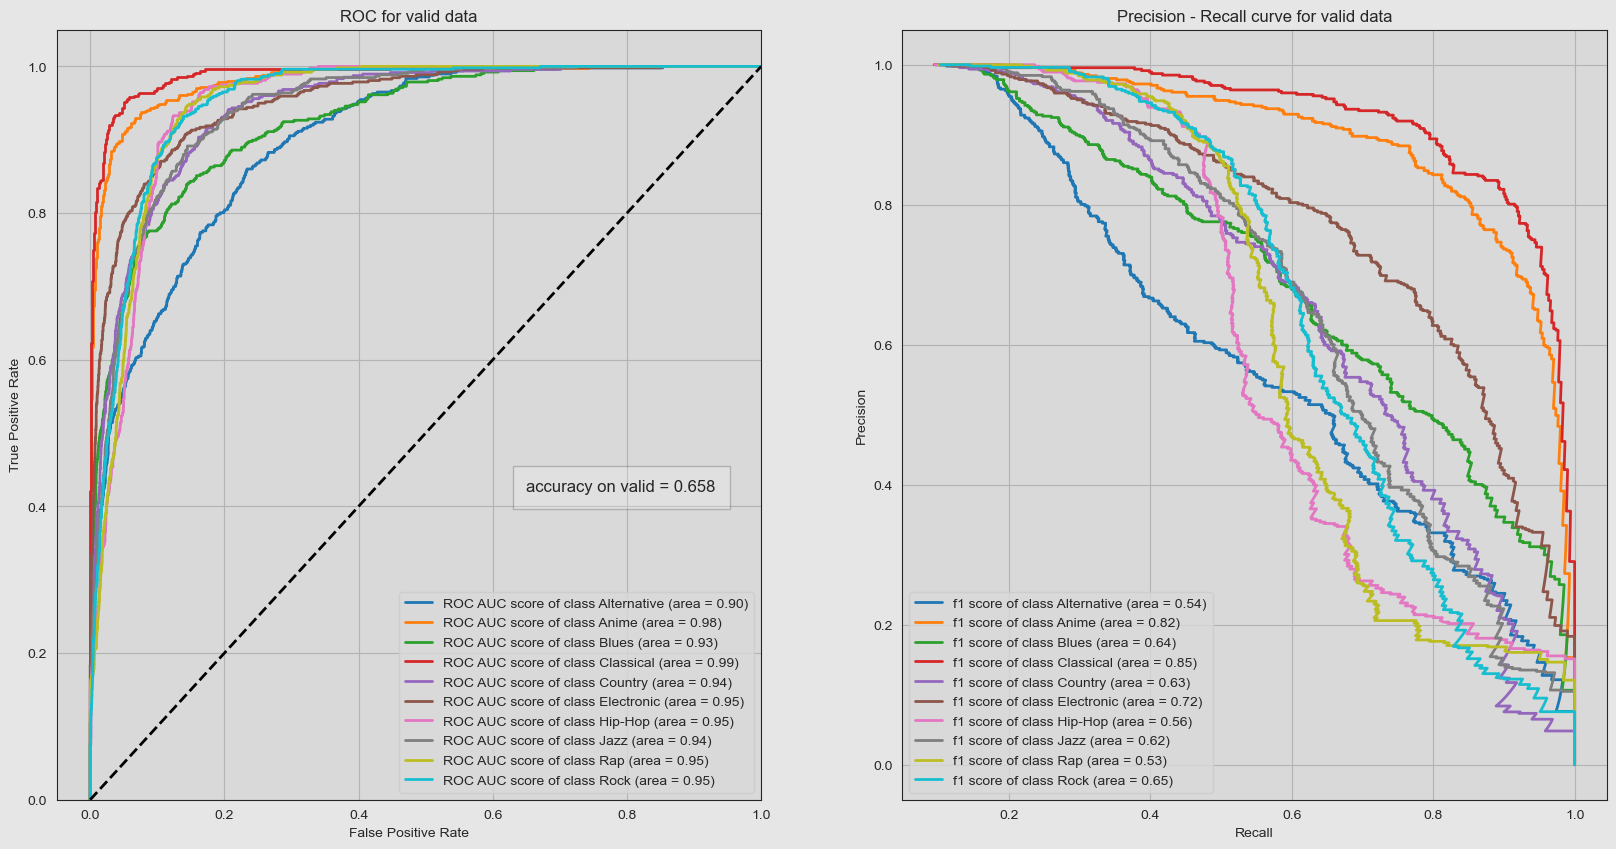

In [39]:
model_GB_1 = fit_model(model_GB, params_GB, 'f1_macro',
                       X_train, X_valid, y_train, y_valid,
                       unique_genres, cv=5)

Значение метрики f1-macro на валидации равняется 0.66.  
Добавим в pipeline метод генерации числовых признаков и SMOTETomek.

In [47]:
params_GB = {
    'catboostclassifier__n_estimators': [256, 512, 1028],
    'catboostclassifier__max_depth': range(7, 10),
    'catboostclassifier__l2_leaf_reg': [0.01, 0.05, 0.1],
    'columntransformer__pipeline__dropcorrelatedfeatures__threshold': [0.8, 0.9]
}

model_GB = cb.CatBoostClassifier()

num_pipeline_GB = make_imblearn_pipeline(PolynomialFeatures(),
                                         DropCorrelatedFeatures(),
                                         DropConstantFeatures())

column_transformer_GB = make_column_transformer((num_pipeline_GB, number_columns),
                                                (OrdinalEncoder(), cat_columns),
                                                remainder='passthrough')

pipeline_GB = make_imblearn_pipeline(column_transformer_GB,
                                     SMOTETomek(),
                                     model_GB)

pipeline_GB.steps

[('columntransformer',
  ColumnTransformer(remainder='passthrough',
                    transformers=[('pipeline',
                                   Pipeline(steps=[('polynomialfeatures',
                                                    PolynomialFeatures()),
                                                   ('dropcorrelatedfeatures',
                                                    DropCorrelatedFeatures()),
                                                   ('dropconstantfeatures',
                                                    DropConstantFeatures())]),
                                   ['popularity', 'acousticness', 'danceability',
                                    'duration_ms', 'energy', 'instrumentalness',
                                    'liveness', 'loudness', 'speechiness',
                                    'tempo', 'valence']),
                                  ('ordinalencoder', OrdinalEncoder(),
                                   ['key', 'mode'])])),
 

Fitting 5 folds for each of 54 candidates, totalling 270 fits
0:	learn: 2.2332249	total: 287ms	remaining: 4m 54s
1:	learn: 2.1699748	total: 391ms	remaining: 3m 20s
2:	learn: 2.1128033	total: 504ms	remaining: 2m 52s
3:	learn: 2.0601739	total: 618ms	remaining: 2m 38s
4:	learn: 2.0168263	total: 729ms	remaining: 2m 29s
5:	learn: 1.9739238	total: 841ms	remaining: 2m 23s
6:	learn: 1.9359317	total: 957ms	remaining: 2m 19s
7:	learn: 1.8984076	total: 1.07s	remaining: 2m 16s
8:	learn: 1.8652559	total: 1.19s	remaining: 2m 14s
9:	learn: 1.8329878	total: 1.3s	remaining: 2m 12s
10:	learn: 1.8011522	total: 1.42s	remaining: 2m 10s
11:	learn: 1.7730693	total: 1.53s	remaining: 2m 9s
12:	learn: 1.7464713	total: 1.64s	remaining: 2m 8s
13:	learn: 1.7216106	total: 1.76s	remaining: 2m 7s
14:	learn: 1.6974169	total: 1.88s	remaining: 2m 6s
15:	learn: 1.6753629	total: 1.99s	remaining: 2m 5s
16:	learn: 1.6545744	total: 2.1s	remaining: 2m 5s
17:	learn: 1.6339909	total: 2.22s	remaining: 2m 4s
18:	learn: 1.6149300	

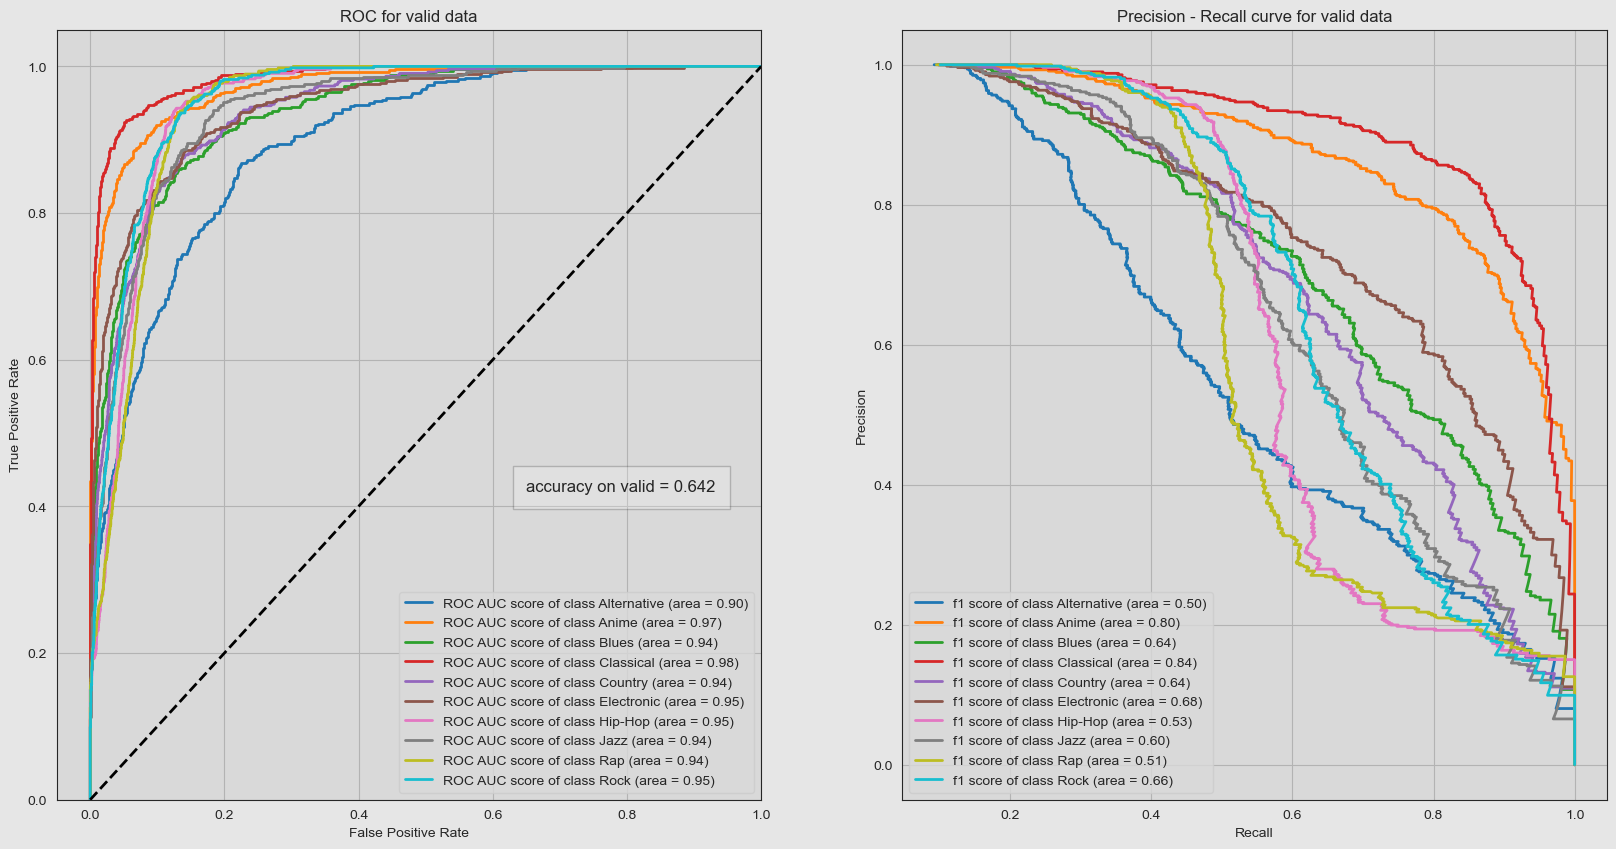

In [48]:
model_GB_2 = fit_model(pipeline_GB, params_GB, 'f1_macro',
                       X_train, X_valid, y_train, y_valid,
                       unique_genres, cv=5)

Повысить качество по метрике f1-macro не удалось.  
Оптимальыне гиперпараметры для градиентного бустинга следующие:  n_estimators = 512, max_depth = 7, l2_leaf_reg = 0.05.

### Вывод по разделу  
В результате исследования моделей лучший результат (f1-macro = 0.66) на валидационной выборке показал градиентный бустинг с гиперпараметрами n_estimators = 512, max_depth = 7, l2_leaf_reg = 0.05.  
Были рассмотрены модели логистической регрессии, случайного леса, градиентного бустинга в сочетании с разлиынми метода шкалирования и генерации числовых признаков и метода оверсэмплинга SMOTE и метода Tomek для улучшения разделимости обучающей выборки.

## Тестирование лучшей модели

Обучим модель градиентного бустинга с оптимальными гиперпараметрами и проверим её качество на тестовом датасете.

In [51]:
model_GB = cb.CatBoostClassifier(n_estimators=512,
                                 max_depth=7,
                                 l2_leaf_reg=0.05,
                                 cat_features = cat_columns)

model_GB.fit(X_train, y_train)

0:	learn: 2.2382395	total: 152ms	remaining: 1m 17s
1:	learn: 2.1797058	total: 285ms	remaining: 1m 12s
2:	learn: 2.1284208	total: 424ms	remaining: 1m 11s
3:	learn: 2.0811685	total: 560ms	remaining: 1m 11s
4:	learn: 2.0370428	total: 698ms	remaining: 1m 10s
5:	learn: 1.9973585	total: 839ms	remaining: 1m 10s
6:	learn: 1.9611002	total: 983ms	remaining: 1m 10s
7:	learn: 1.9279890	total: 1.12s	remaining: 1m 10s
8:	learn: 1.8961979	total: 1.26s	remaining: 1m 10s
9:	learn: 1.8689588	total: 1.4s	remaining: 1m 10s
10:	learn: 1.8413328	total: 1.54s	remaining: 1m 10s
11:	learn: 1.8158649	total: 1.68s	remaining: 1m 10s
12:	learn: 1.7911346	total: 1.82s	remaining: 1m 9s
13:	learn: 1.7684985	total: 1.95s	remaining: 1m 9s
14:	learn: 1.7470879	total: 2.12s	remaining: 1m 10s
15:	learn: 1.7249312	total: 2.28s	remaining: 1m 10s
16:	learn: 1.7043567	total: 2.42s	remaining: 1m 10s
17:	learn: 1.6849979	total: 2.55s	remaining: 1m 10s
18:	learn: 1.6674607	total: 2.69s	remaining: 1m 9s
19:	learn: 1.6508618	total

classification report on valid 
               precision    recall  f1-score   support

           0       0.58      0.50      0.54       504
           1       0.83      0.76      0.80       479
           2       0.69      0.60      0.64       513
           3       0.84      0.87      0.86       485
           4       0.64      0.67      0.66       505
           5       0.72      0.67      0.69       490
           6       0.53      0.58      0.55       499
           7       0.61      0.60      0.60       494
           8       0.56      0.53      0.54       544
           9       0.57      0.77      0.66       487

    accuracy                           0.65      5000
   macro avg       0.66      0.66      0.65      5000
weighted avg       0.66      0.65      0.65      5000



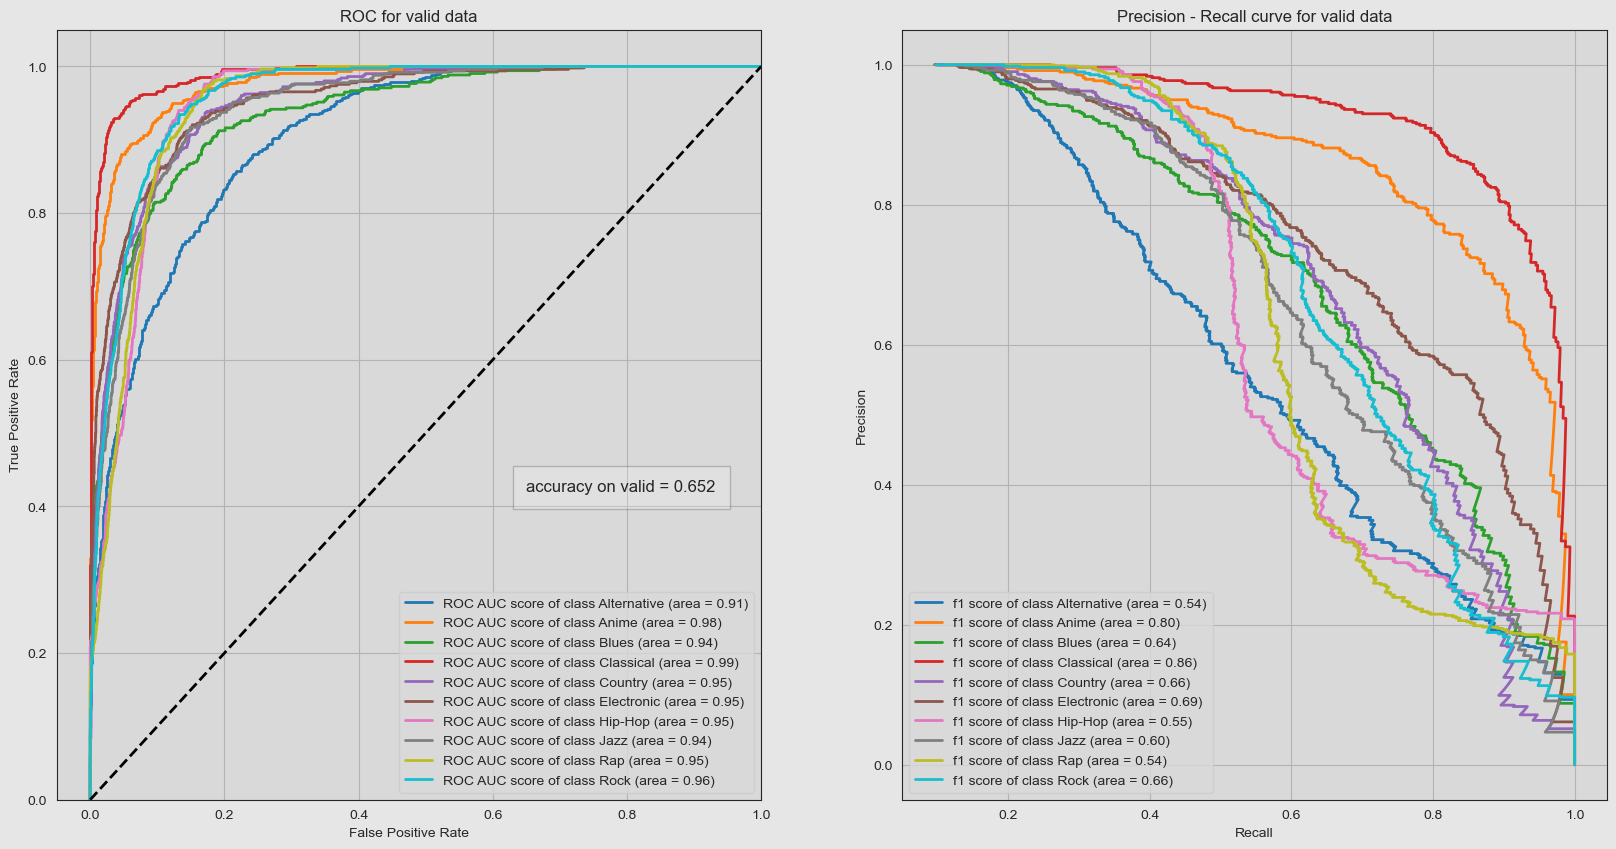

In [50]:
check_model(model_GB, 
            X_test, 
            y_test,
            unique_genres)

На тестовом датасете значение метрики f1-macro = 0.65.

## Анализ важности признаков

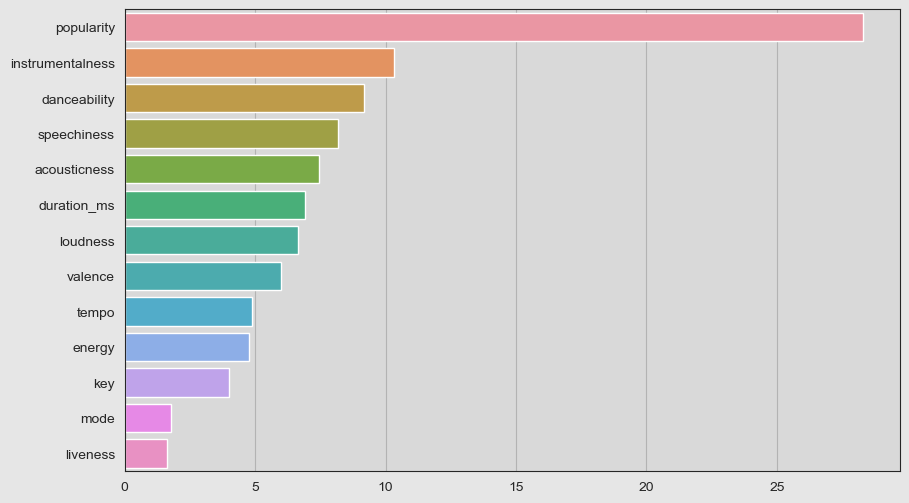

In [42]:
feature_importances = pd.Series(model_GB.get_feature_importance(), 
                                index=X_test.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances.values, 
            y=feature_importances.index)
plt.show()

Как видно из вышепредставленной диаграммы, наиболее значимыми признаками являются popularity, instrumentalness, danceability, speechiness, acousticness. Наименее важные признаки: liveness, mode.

Посмотрим на важность признаков для каждого значения таргета

In [68]:
explainer = shap.TreeExplainer(model_GB)
shap_values = explainer(X_train)

Alternative

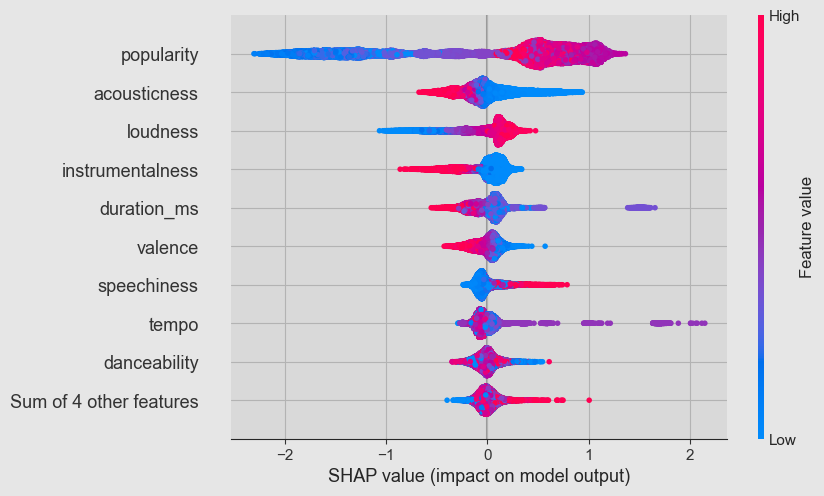

In [75]:
shap.plots.beeswarm(shap_values[:, :, 0])

Для жанра Alternative наиболее значимыми признаками являются popularity, acousticness, loudness, instrumentalness.  
Жанр характеризуется высокой популярностью треков, слабым уровнем акустичности, низкой инструментальностью, высоким уровнем громкости и красноречивости. 

Anime

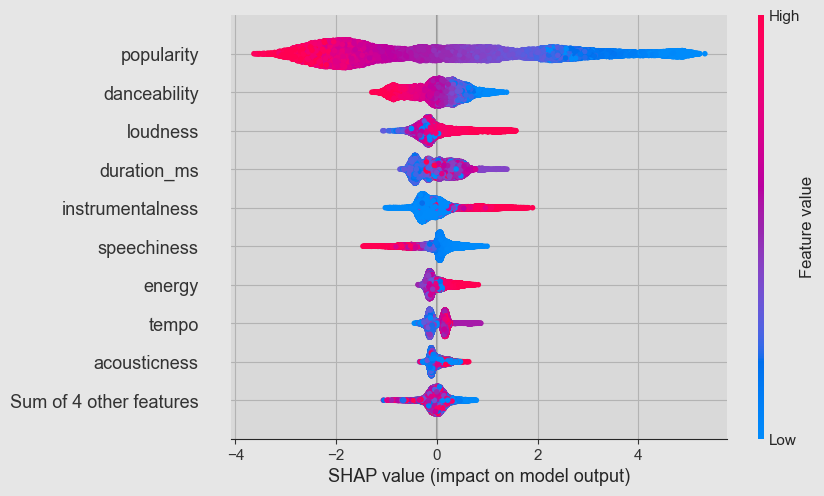

In [77]:
shap.plots.beeswarm(shap_values[:, :, 1])

Для жанра Anime наиболее значимыми признаками являются popularity, danceability, loudness, instrumentalness.  
Жанр характеризуется низкими уровнями популярности и танцевальности, высокими уровнями громкости и инструментальности, также низким уровнем красноречивости.

Blues

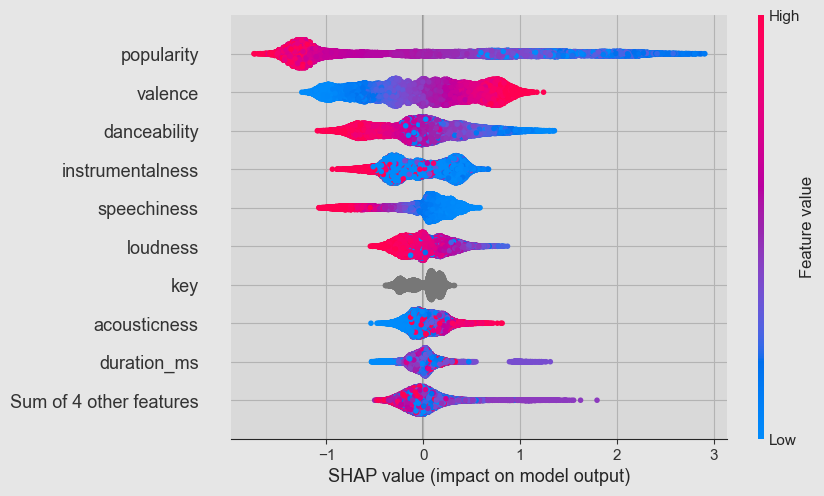

In [78]:
shap.plots.beeswarm(shap_values[:, :, 2])

Для жанра Blues наиболее значимыми признаками являются popularity, valence, danceability, instrumentalness.  
Жанр характеризуется низким уровнем популярности, низкими уровнями танцевальности и инструментальности, высоким уровнем валентности.

Classical

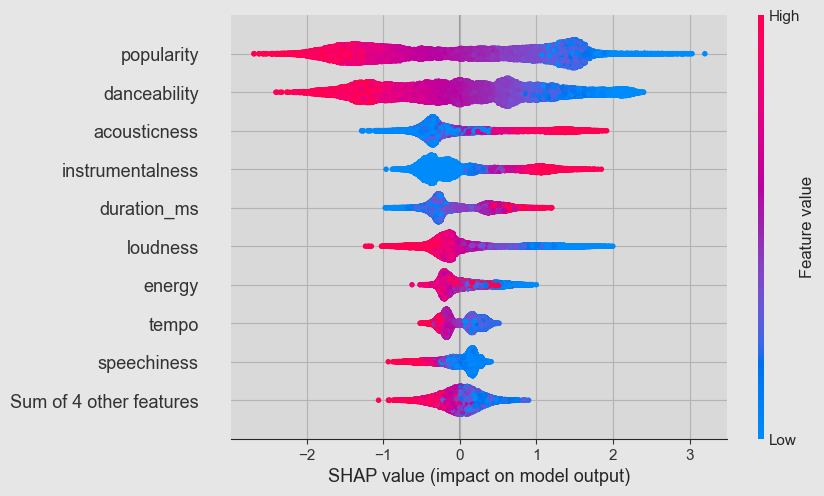

In [76]:
shap.plots.beeswarm(shap_values[:, :, 3])

Для жанра Classical наиболее значимыми признаками являются popularity, danceability, acousticness, instrumentalness.  
Жанр характеризуется низкими уровнями популярности и танцевальности, высокими уровнями акустичности и инструментальности.   

Country

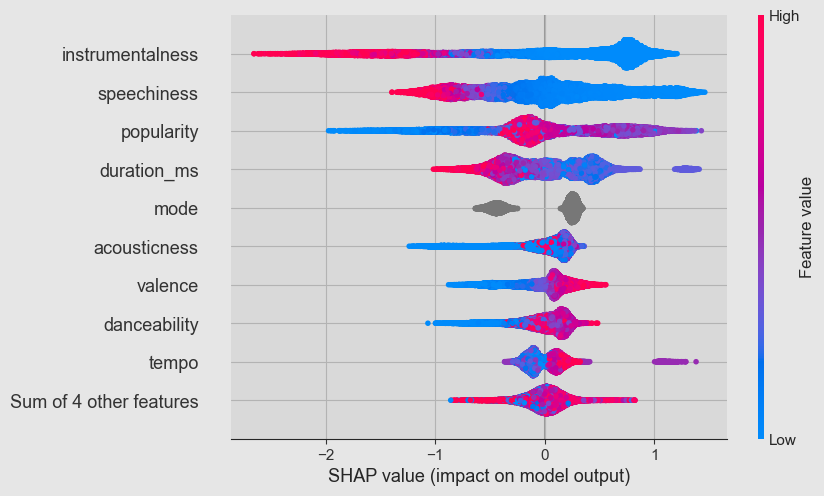

In [79]:
shap.plots.beeswarm(shap_values[:, :, 4])

Для жанра Country наиболее значимыми признаками являются instrumentalness, speechiness, popularity, duration_ms.  
Жанр характеризуется слабыми инструментальностью и красноречивостью, средней популярностьюи и низкой длительностью треков.

Electronic

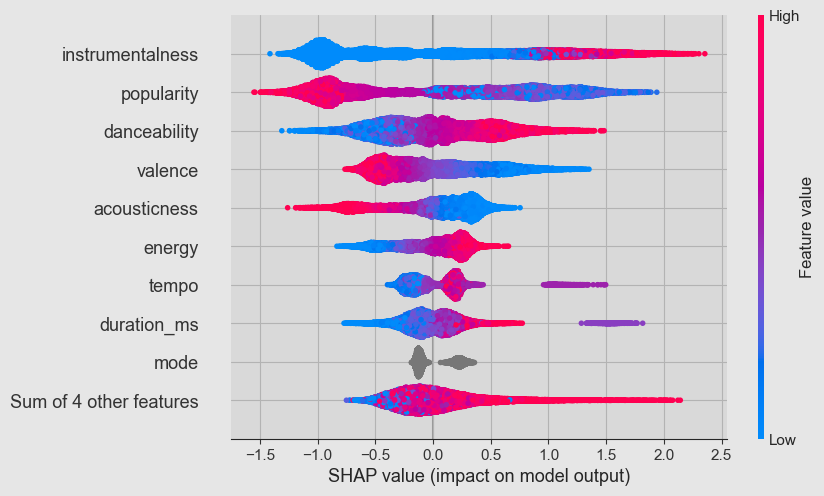

In [80]:
shap.plots.beeswarm(shap_values[:, :, 5])

Для жанра Electronic наиболее значимыми признаками являются intrumentalness, popularity, danceability, valence, acousticness.  
Жанр характеризуется высокими уровнями инструментальности и танцевальности, низкой популярностью, низкими уровнями валентности и акустичности.

Hip-Hop

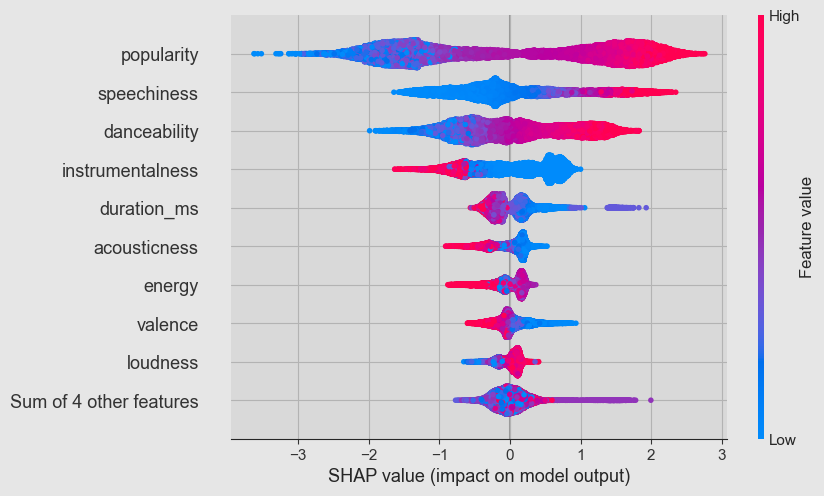

In [81]:
shap.plots.beeswarm(shap_values[:, :, 6])

Для жанра Hip-Hop наиболее значимыми признаками являются popularity, speechiness, danceability, instrumentalness.  
Жанр характеризуется высокими популярностью, красноречивостью и танцевальностью, низким уровнем инструментальности.

Jazz

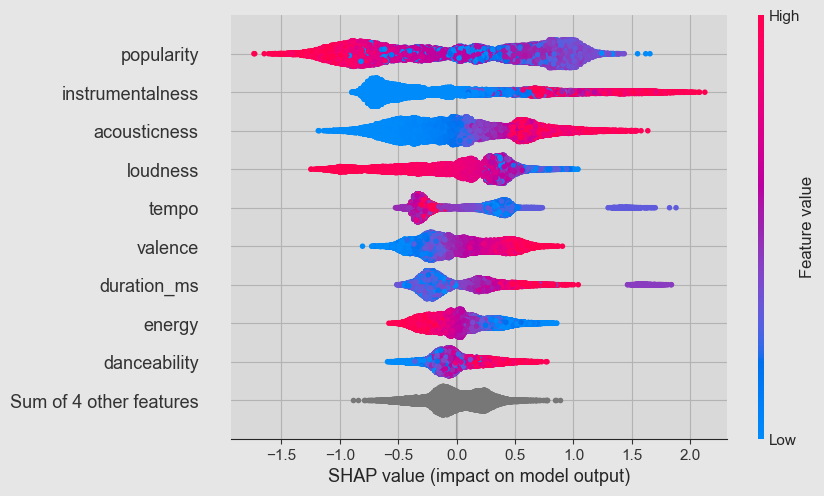

In [82]:
shap.plots.beeswarm(shap_values[:, :, 7])

Для жанра Jazz наиболее значимыми признаками являются popularity, instrumentalness, acousticness, loudness.  
Жанр характеризуется низкой популярностью и громкостью, высокими уровнями инструментальности и акустичности.

Rap

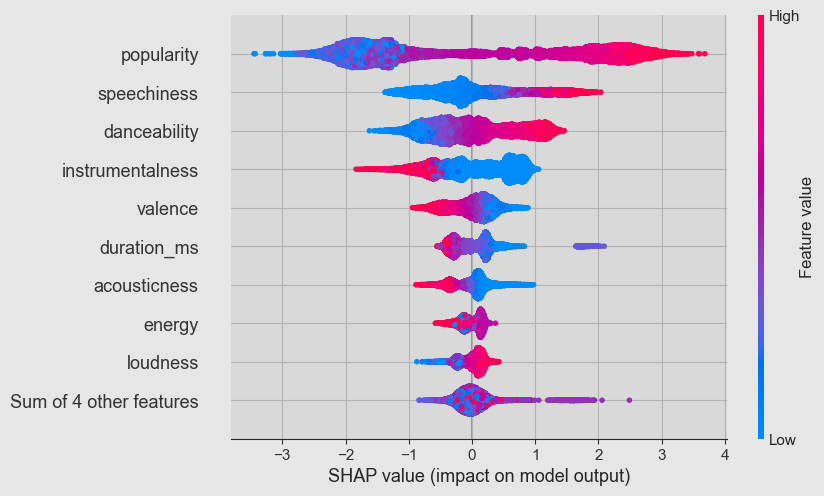

In [83]:
shap.plots.beeswarm(shap_values[:, :, 8])

Для жанра Rap наиболее значимыми признаками являются popularity, speechiness, danceability, instrumentalness.  
Жанр характеризуется высокой популярностью, красноречивостью и танцевальностью, низким уровнем инструментальности.

Rock

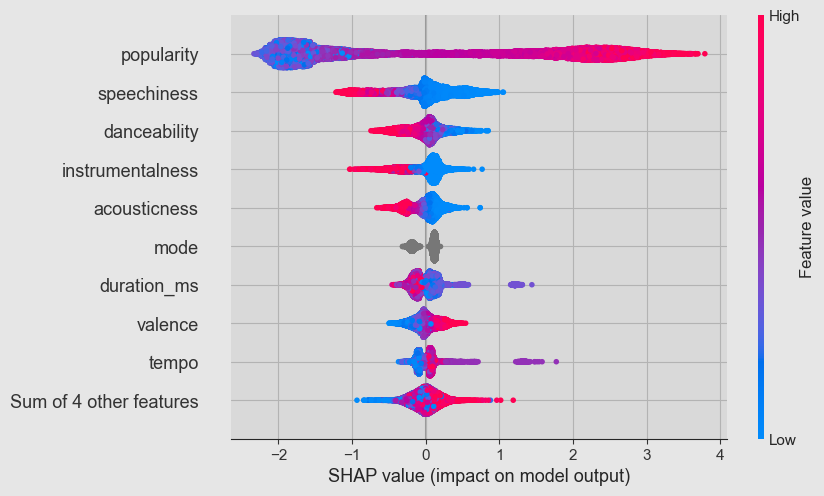

In [84]:
shap.plots.beeswarm(shap_values[:, :, 9])

Для жанра Rock наиболее значимыми признаками являются popularity, speechiness, danceability, instrumentalness.  
Жанр характеризуется высоким уровнем популярности, низкой красноречивостью, танцевальностью и инструментальностью.

Выводы по анализу признаков: 
- В целом для модели наиболее значимыми признаками являются popularity, instrumentalness, danceability, speechiness, acousticness.  
- Примечательно, что популярность является ключевым параметром в оценке музыкальных треков.  
- Только для двух жанров (Country и Electronic) popularity не является ключевым признаком.  
- Категориальные признаки key и mode практически не используются для предсказания жанра музыкальных треков.  
- В общем можно сделать вывод, что данное признаковое описание треков мало пригодно для достоверной оценки жанров композиций. Все жанры кроме Classical имеют значительные пересечения в распределения признаков, что затрудняет их классификацию и не позволяет качественно разделять значения таргета.

## Общий вывод по проекту  

Для решения задачи классификации музыкальных треков по жанрам были выполнены следующие действия:  
- Подготовка датасета:  
Были удалены пропуски, всего их было обнаружено 5 записей.  
Также были удалены неинформативные признаки, такие как instance_id, obtained_date, artist_name, track_name не отражающие значимую информацию о треках. В признаках tempo и duration_ms некорректные значения были заменены на медианные для каждого жанра соответственно. Датасет был разделен на тренировочную, валидационную и тестовую выборки.

- Исследовательский анализ:  
Признаковое описание для жанра classical наибольшим образом отличается от других жанров. У признака danceability медианные значения для каждого жанра отличаются больше, чем у других признаков. В общем проследить четкие различия между музыкальными жанрами сложно. В большинстве случаев распределения признаков схожи, пересекаются, имеют сопоставимые характеристики.  Между признаками acousticness, energy и loudness была обнаружена отрицательная корреляция Пирсона, между признаками energy и loudness положительная корреляция. Матрица phik-корреляции подтвердила связь между признаками acousticness, energy и loudness. С таргетом сильно коррелируют признаки popularity, energy, loudness, acousticness, danceability. Дубликатов в датасете обнаружено не было. Целевая переменная является сбалансированной, доли всех классов одинаковы.  

- Исследование моделей:  
Были исследованы модели линейной регрессии, случайного леса и градиетного бустинга. Сравнение моделей осущствлялось по метрике f1-macro. При подборе оптимального пайплайна исследовались гиперпараметры моделей, различные методы масштабирования числых признаков, методы генерации числовых признаков на основе возведения их в степень с последующим отсеиванием признаков с высокой степенью корреляции. Иакже использовалась метод SMOTETomek для повышения разделимости классов целевой переменной. В результате исследования моделей лучший результат (f1-macro = 0.66) на валидационной выборке показала модель градиентного бустинга с гиперпараметрами n_estimators = 512, max_depth = 7, l2_leaf_reg = 0.05.

- Анализ важности признаков:  
В целом для модели наиболее значимыми признаками являются popularity, instrumentalness, danceability, speechiness, acousticness.  
Примечательно, что популярность является ключевым параметром в оценке музыкальных треков.  
Только для двух жанров (Country и Electronic) popularity не является ключевым признаком.  
Категориальные признаки key и mode практически не используются для предсказания жанра музыкальных треков.  
В общем можно сделать вывод, что данное признаковое описание треков мало пригодно для достоверной оценки жанров композиций. Все жанры кроме Classical имеют значительные пересечения в распределения признаков, что затрудняет их классификацию и не позволяет качественно разделять значения таргета.